# Prediction de l'accélération et du freinage avec nuScenes

L'objectif de ce notebook est d'essayer de prédire l'accélération et le freinage d'un véhicule par rapport à un véhicule qui se situe en face lui, en utilisant le jeu de données nuScenes. Prédire l'accélération et le freinage revient à prédire la vitesse à l'instant t+1 et à ensuite calculer si c'est une accélération ou un freinage.

In [1]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
from nuscenes.can_bus.can_bus_api import NuScenesCanBus
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
C:\Users\Alexandre\anaconda3\envs\nu\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


Le chargement du jeu de données est nécéssaire que pour la partie 1/ et la partie 2/ jusqu'à "Chargement des données", le reste peut se faire seulement avec les fichiers .csv dans le dossier data.

In [2]:
# data/sets/nuscenes
# D:\Utilisateurs\Alexandre\Repertoire_D\nuscenes\v1 0-trainval01
#nusc = NuScenes(version='v1.0-mini', dataroot='../data/sets/nuscenes')
#nusc = NuScenes(version='v1.0-trainval', dataroot='G:/repertoire_g/datafull')
nusc = NuScenes(version='v1.0-trainval', dataroot='D:/Utilisateurs/Alexandre/Repertoire_D/nuscenes/v1.0-trainval01')
#nusc = NuScenes(version='v1.0-mini', dataroot='G:/repertoire_g/data/sets/nuscenes')

nusc_can = NuScenesCanBus(dataroot='../data/sets/nuscenes')
#nusc_can = NuScenesCanBus(dataroot='G:/repertoire_g/data/sets/nuscenes')


Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 48.0 seconds.
Reverse indexing ...
Done reverse indexing in 8.3 seconds.


# Anticiper la vitesse avec un véhicule en face

Principe de base: 
- le système de pilotage envoie les postions gps à suivre, la vitesse et l'angle recommandés à l'algorithme de gestion
- l'algorithme de gestion en fonction de la situation va envoyer sur un modèle pour donner une nouvelle valeur de la vitesse et de l'angle par rapport à l'environnement
- plusieurs modèles, mais en premier un basique : s'il y a aucun véhicule en face on change rien, sinon calcul de la nouvelle vitesse par rapport au véhicule devant. Pour cela, il nous faut plusieurs données pour ce modèle: comme la position, la vitesse, orientation du véhicule égo (nous) et du véhicule en face, etc...

Je me suis focalisé sur le dernier point, et je n'ai pas pu traiter le reste.

# 1/ Recherche de ces données

Prenons une scene où on suit une voiture, la scène 61. Cherchons l'instance de la voiture.... On voit qu'on a accès à plusieurs informations comme le premier et dernier token de la scène.

In [3]:
scene_test = nusc.scene[0] # indice 58 avec le dataset normal #0 avec le minidataset
scene_test

{'token': '73030fb67d3c46cfb5e590168088ae39',
 'log_token': '6b6513e6c8384cec88775cae30b78c0e',
 'nbr_samples': 40,
 'first_sample_token': 'e93e98b63d3b40209056d129dc53ceee',
 'last_sample_token': '40e413c922184255a94f08d3c10037e0',
 'name': 'scene-0001',
 'description': 'Construction, maneuver between several trucks'}

On regarde ce qu'il y a dans le premier token de la scène. On peut voir les différents token qui font références aux captures des caméras/ radars et lidar. Ainsi qu'une liste 'anns' qui fait référence aux objets détéctes dans la scène (annotation) pour cet enregistrement, qui eux même sont reliés à une instance qui leur est propre qui permet de faire le lien entre les autres annotations des autres enregistrements.

In [8]:
sample = nusc.get('sample',scene_test['first_sample_token'])
ann = sample['anns'][1]
ann_meta = nusc.get('sample_annotation', ann)
#nusc.list_sample(sample['token'])
sample

{'token': 'e93e98b63d3b40209056d129dc53ceee',
 'timestamp': 1531883530449377,
 'prev': '',
 'next': '14d5adfe50bb4445bc3aa5fe607691a8',
 'scene_token': '73030fb67d3c46cfb5e590168088ae39',
 'data': {'RADAR_FRONT': 'bddd80ae33ec4e32b27fdb3c1160a30e',
  'RADAR_FRONT_LEFT': '1a08aec0958e42ebb37d26612a2cfc57',
  'RADAR_FRONT_RIGHT': '282fa8d7a3f34b68b56fb1e22e697668',
  'RADAR_BACK_LEFT': '05fc4678025246f3adf8e9b8a0a0b13b',
  'RADAR_BACK_RIGHT': '31b8099fb1c44c6381c3c71b335750bb',
  'LIDAR_TOP': '3388933b59444c5db71fade0bbfef470',
  'CAM_FRONT': '020d7b4f858147558106c504f7f31bef',
  'CAM_FRONT_RIGHT': '16d39ff22a8545b0a4ee3236a0fe1c20',
  'CAM_BACK_RIGHT': 'ec7096278e484c9ebe6894a2ad5682e9',
  'CAM_BACK': 'aab35aeccbda42de82b2ff5c278a0d48',
  'CAM_BACK_LEFT': '86e6806d626b4711a6d0f5015b090116',
  'CAM_FRONT_LEFT': '24332e9c554a406f880430f17771b608'},
 'anns': ['173a50411564442ab195e132472fde71',
  '5123ed5e450948ac8dc381772f2ae29a',
  'acce0b7220754600b700257a1de1573d',
  '8d7cb5e96cae48c39

On liste les diffétentes annotations qui sont des véhicules, puis on fait un rendu sur la voiture qu'on est en train de suivre.

{'token': 'acce0b7220754600b700257a1de1573d', 'sample_token': 'e93e98b63d3b40209056d129dc53ceee', 'instance_token': '39b6c31c9925492a8a9f1b0ef3b877b6', 'visibility_token': '4', 'attribute_tokens': ['58aa28b1c2a54dc88e169808c07331e3'], 'translation': [1002.464, 632.267, 1.936], 'size': [2.312, 7.516, 3.093], 'rotation': [0.9343569321017062, 0.0, 0.0, -0.35633849558178193], 'prev': '', 'next': '4b1c1acb00c04dfe84e54f64a8381649', 'num_lidar_pts': 171, 'num_radar_pts': 7, 'category_name': 'vehicle.truck'} 

{'token': '8d7cb5e96cae48c39ef4f9f75182013a', 'sample_token': 'e93e98b63d3b40209056d129dc53ceee', 'instance_token': 'f7c451dfcd2a4587b3af322d081dddad', 'visibility_token': '4', 'attribute_tokens': ['cb5118da1ab342aa947717dc53544259'], 'translation': [1018.705, 605.045, 0.731], 'size': [1.638, 4.25, 1.44], 'rotation': [0.9930201651831624, 0.0, 0.0, 0.11794469695414371], 'prev': '', 'next': '3b3734f6209a4317bb8734bcc1e6305f', 'num_lidar_pts': 150, 'num_radar_pts': 2, 'category_name': 'veh

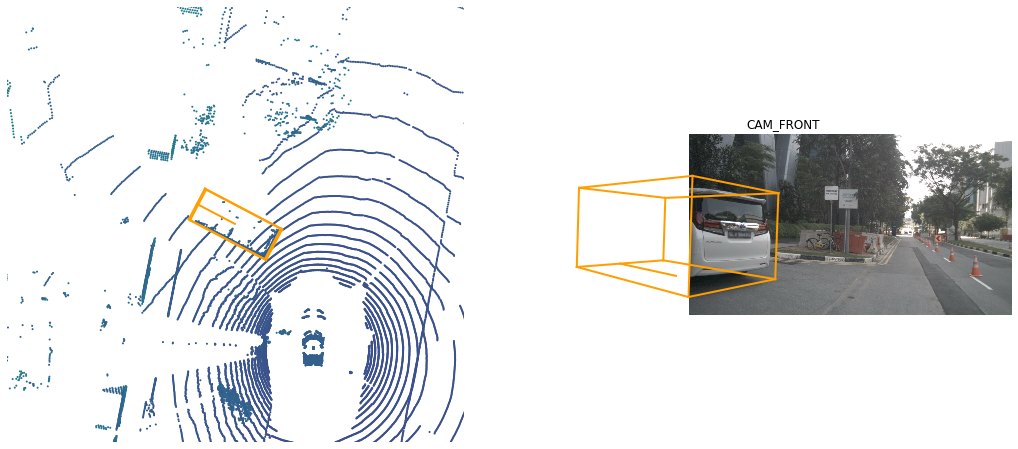

In [10]:
liste_vehicle = []
for at in sample['anns']:
    meta_data = nusc.get('sample_annotation',at)
    if  'vehicle' in meta_data['category_name']: 
        liste_vehicle += [meta_data]
        print(meta_data,'\n')
nusc.render_annotation("bc3180b07f8e4a728f504ded654df56f")

Token de l'instance de la voiture que l'on suit: `c1958768d48640948f6053d04cffd35b`, son annotation pour cet enregistrement: `bc3180b07f8e4a728f504ded654df56f`

Maintenant, comparons la position de cette voiture à la notre (ego). Pour cela, `field2token` permet d'accéder à la liste de tout les enregistrements d'une scene. Ensuite on parcours chaque annotation et on récupère le sample qui lui est associé, on récupère ensuite le token du lidar puis sa position et sa rotation dans le monde (qui est la même que le véhicule). On mets ensuite la position et la rotation de la voiture qui est devant et la notre dans deux tableaux différents.
On peut aussi récupérer la position avec CAN Bus.

In [11]:
ann_tokens = set(nusc.field2token('sample_annotation','instance_token',"c1958768d48640948f6053d04cffd35b"))
def print_pos_rot(pos,rot):
    print("{:04.2f} {:04.2f} {:04.2f}".format(pos[0],pos[1],pos[2]))
    print("{:04.2f} {:04.2f} {:04.2f}".format(rot[0],rot[1],rot[2]))

ego_pos = []
voiture_pos = []
ego_rot = []
voiture_rot = []
for at in ann_tokens:
    meta_data = nusc.get('sample_annotation',at)
    sample = nusc.get('sample',meta_data['sample_token'])
    timestamp = sample['timestamp']
    lidar = nusc.get('sample_data',sample['data']['LIDAR_TOP'])
    ego_token = lidar['ego_pose_token']
    ego = nusc.get('ego_pose',ego_token)
    #print_pos_rot(ego['translation'],ego['rotation'])
    #print_pos_rot(meta_data['translation'],meta_data['rotation'])
    #print(meta_data['rotation'])
    ego_pos += [ego['translation']]
    ego_rot += [ego['rotation']]
    voiture_pos += [meta_data['translation']]
    voiture_rot += [meta_data['rotation']]    


Maintenant qu'on a les données de position de notre véhicule et celui d'en face, on peut essayer de visualiser sur un graph ce qu'il en est pour pouvoir avoir un premier aperçu.
L'un des problèmes est que la rotation est en écriture quaternion (je ne sais pas comment manipuler), donc en attendant je vais essayer de détecter le véhicule en face par rapport à s'il est détecté par la caméra frontale puis en calculant la distance.

Le graphique montre bien que les deux véhicules tournent à une intersection, comme l'a montré le rendu.

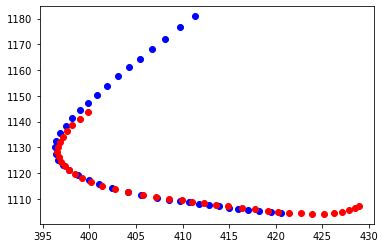

In [12]:
df_ego_pos = pd.DataFrame(ego_pos,columns=["x","y","z"])
#print(ego_rot)
#df_ego_rot = pd.DataFrame(ego_rot,columns=["x","y","z"])
df_voiture_pos = pd.DataFrame(voiture_pos,columns=["x","y","z"])
#df_voiture_rot = pd.DataFrame(voiture_rot,columns=["x","y","z"])
plt.plot(df_ego_pos["x"],df_ego_pos["y"],'bo')
plt.plot(df_voiture_pos["x"],df_voiture_pos["y"],'ro')

# 2/ Pretraitement sur les données

## Récupération des véhicules présents sur la caméra frontale

En regardant le code du sdk j'ai trouvé un bout de code utile qui me permet de savoir quel caméra a détecté l'annotation. Pour faire simple, on va considérer pour commencer qu'une voiture est en face de la notre si elle est détectée par la caméra frontale et qu'elle respecte une certaine distance.

`get_sample_data` renvoie plusieurs informations dont une liste de boxe de la caméra, si on lui passe un token en paramètre, il renvoie une seul boxe si l'instance est capturé par la caméra, rien sinon.

On peut maintenant créer un dataframe, où chaque ligne représente un véhicule détecté par la caméra frontale, qui va contenir toutes les informations dont on a besoin: vitesse,distance,timestamp,accélération, token....
Voir `vehicle_data_X.csv` dans `./data`.

Il faut savoir que chaque enregristrement a un temps associé `timestamp` et dans CAN Bus il y a un auter temps associé `utime` mais qui n'est pas le même, il y a un décalage entre les deux (qui ne change pas dans la scène), ce qui se traduit dans le code par une deuxième boucle while tant que utime < timestamp, cela peut donc créer un décalage d'une demi seconde par rapport à l'enregistrement, j'ai essayé de réduire ce décalage mais je n'ai pas réussi, donc je reste sur cette version.

Deux fonctions similaire `vehicle_info` et `find_vehicle_in_front` qui renvoient un tableau avec les données à ajouter au dataframe.

In [13]:
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility
# Renvoie un tableau rempli pour toute la scene avec les données du véhicule
def vehicle_info(scene):
    curr_token = scene['first_sample_token']
    rows_list = []
    last_token = scene['last_sample_token']
    i = 0

    # On récupère le dictionnaire des informations du véhicle pour la scène 
    # (voir nuscenes_decouverte pour plus de détails)
    dict_scene = nusc_can.get_messages(scene['name'],'vehicle_monitor') 
    taille = len(dict_scene)
    
    # Pour chaque enregistrement de la scene on ajoute une ligne avec les elements
    while curr_token != last_token:
        curr_sample = nusc.get('sample',curr_token)
        # On recupère le temps utime de Can Bus qui est supérieur au timestamp et le plus proche
        while i < taille -2 and  (dict_scene[i]['utime']  < curr_sample['timestamp']):
            i += 1
            
        # On récupère la position de la voiture Ego
        lidar = nusc.get('sample_data',curr_sample['data']['LIDAR_TOP'])
        ego = nusc.get('ego_pose',lidar['ego_pose_token'])
        ego_pos = [round(e,3) for e in ego['translation']]
        
        # On mets toutes les informations dans un dictionnaire puis on l'ajoute dans le tableau
        dic = {'scene':scene['name'],'timestamp':curr_sample['timestamp'],'utime':dict_scene[i]['utime'],
               'inst_token':"vehicle_info",'ann_token':curr_token,'ego_pos':ego_pos,'object_pos':ego_pos,
               'distance':99,'steering':round(dict_scene[i]['steering'],3),
               'ego_speed':round(dict_scene[i]['vehicle_speed'],3),'throttle':dict_scene[i]['throttle'],
               'brake':dict_scene[i]['brake'],'future_throttle':dict_scene[i+1]['throttle'],
               'future_brake':dict_scene[i+1]['brake'],'futur_speed':round(dict_scene[i+1]['vehicle_speed'],3)}
        rows_list += [dic]
        curr_token = curr_sample['next']   
        if i < taille - 2:
            i += 1
    #print(len(rows_list),len(dict_scene))
    return rows_list

In [14]:
# Renvoie vrai et un un tableau rempli si l'instance est en face d'ego et ego ne tourne pas trop
def find_vehicle_in_front(instance_token):
    
    # Récupération des informations de base  
    instance = nusc.get('instance',instance_token)
    last_token = instance["last_annotation_token"]
    curr_token = instance["first_annotation_token"]
    ann = nusc.get('sample_annotation',instance["first_annotation_token"])
    sample = nusc.get('sample',ann['sample_token'])
    scene = nusc.get('scene',sample['scene_token'])
    
    # On récupère le dictionnaire des informations du véhicle pour la scène 
    # (voir nuscenes_decouverte pour plus de détails)
    dict_scene = nusc_can.get_messages(scene['name'],'vehicle_monitor') 
    taille = len(dict_scene)
    i = 0
    rows_list = []
        
    # Pour chaque enregistrement de l'annoation on ajoute une ligne avec les elements
    while curr_token != last_token:
        
        curr_ann = nusc.get('sample_annotation',curr_token)
        curr_sample = nusc.get('sample',curr_ann['sample_token'])        
        cams_check = []
        # On recupère le temps utime de Can Bus qui est supèrieur au timestamp et le plus proche
        while i < taille - 2 and   (dict_scene[i]['utime'] < curr_sample['timestamp']):
            i += 1
            
        # Renvoie une boxe si l'annotation est détécté par la caméra frontale
        _, boxes, _ = nusc.get_sample_data(curr_sample['data']['CAM_FRONT'], box_vis_level=BoxVisibility.ANY,
                                                selected_anntokens=[curr_token])
        # S'il y a une boxe, le vehicule est donc détécté par la caméra frontale
        if len(boxes) > 0:
            
            # Calcul distance entre ego et le vehicule
            lidar = nusc.get('sample_data',curr_sample['data']['LIDAR_TOP'])
            ego = nusc.get('ego_pose',lidar['ego_pose_token'])
            dist = np.linalg.norm(np.array(ego['translation']) - np.array(curr_ann['translation']))
            ego_pos = [round(e,3) for e in ego['translation']]
            object_pos = [round(e,3) for e in curr_ann['translation']]
            
            # On mets toutes les informations dans un dictionnaire puis on l'ajoute dans le tableau
            dic = {'scene':scene['name'],'timestamp':curr_sample['timestamp'],'utime':dict_scene[i]['utime'],
                   'inst_token':instance_token,'ann_token':curr_token,'ego_pos':ego_pos,'object_pos':object_pos,
                   'distance':round(dist,3),'steering':round(dict_scene[i]['steering'],3),
                   'ego_speed':round(dict_scene[i]['vehicle_speed'],3),
                   'throttle':dict_scene[i]['throttle'],'brake':dict_scene[i]['brake'],
                   'future_throttle':dict_scene[i+1]['throttle'],
                   'future_brake':dict_scene[i+1]['brake'],'futur_speed':round(dict_scene[i+1]['vehicle_speed'],3)}
            rows_list += [dic]
                
        curr_token = curr_ann['next']   
        if i < taille - 2:
            i += 1
    return len(rows_list)!=0,rows_list

Appelons cette dernière fonction avec l'instance du véhicule qu'on a vu précédemment

In [15]:
_ ,dic = find_vehicle_in_front("c1958768d48640948f6053d04cffd35b")
print(dic[0])
df = pd.DataFrame.from_dict(dic).sort_values(by='timestamp').reset_index(drop=True)
display(df)

{'scene': 'scene-0061', 'timestamp': 1532402927647951, 'utime': 1532402928127800, 'inst_token': 'c1958768d48640948f6053d04cffd35b', 'ann_token': '49f76277d07541c5a584aa14c9d28754', 'ego_pos': [411.304, 1180.89, 0.0], 'object_pos': [399.863, 1143.574, 0.738], 'distance': 39.038, 'steering': 3.0, 'ego_speed': 31.44, 'throttle': 0, 'brake': 0, 'future_throttle': 0, 'future_brake': 0, 'futur_speed': 30.73}


,scene,timestamp,utime,inst_token,ann_token,ego_pos,object_pos,distance,steering,ego_speed,throttle,brake,future_throttle,future_brake,futur_speed
0,scene-0061,1532402927647951,1532402928127800,c1958768d48640948f6053d04cffd35b,49f76277d07541c5a584aa14c9d28754,"[411.304, 1180.89, 0.0]","[399.863, 1143.574, 0.738]",39.038,3.0,31.44,0,0,0,0,30.73
1,scene-0061,1532402928147847,1532402928627159,c1958768d48640948f6053d04cffd35b,ae589a5a2bdb4813ae8021cd51b7e6eb,"[409.743, 1176.677, 0.0]","[398.996, 1141.132, 0.738]",37.142,3.5,30.73,0,0,0,0,29.45
2,scene-0061,1532402928698048,1532402929127810,c1958768d48640948f6053d04cffd35b,e7a2133afb9c4c9b834225cc959d475a,"[408.102, 1172.152, 0.0]","[398.116, 1138.632, 0.738]",34.983,3.6,29.45,0,0,0,0,28.09
3,scene-0061,1532402929197353,1532402929627057,c1958768d48640948f6053d04cffd35b,5a390e5c3f6249bb9f99c9be52614dd2,"[406.726, 1168.211, 0.0]","[397.624, 1136.322, 0.738]",33.171,3.6,28.09,0,0,0,0,27.07
4,scene-0061,1532402929697797,1532402930127656,c1958768d48640948f6053d04cffd35b,0e5ab4ede0ad4cafaee8de500415e29a,"[405.409, 1164.354, 0.0]","[397.133, 1134.052, 0.738]",31.421,3.5,27.07,0,0,0,0,26.25
5,scene-0061,1532402930152601,1532402930627445,c1958768d48640948f6053d04cffd35b,4a8dd530b1144dd1b8217dbe74b60e63,"[404.278, 1161.05, 0.0]","[396.794, 1132.149, 0.738]",29.863,3.6,26.25,0,0,0,0,25.35
6,scene-0061,1532402930648325,1532402931127168,c1958768d48640948f6053d04cffd35b,92a23fb25b98444e93afd004ca31cca2,"[403.115, 1157.518, 0.0]","[396.625, 1130.226, 0.763]",28.063,4.0,25.35,0,0,0,0,24.51
7,scene-0061,1532402931198511,1532402931627135,c1958768d48640948f6053d04cffd35b,5e5e0db2bcf642d680865d7c88a62f76,"[401.882, 1153.723, 0.0]","[396.575, 1128.037, 0.788]",26.240,4.7,24.51,0,0,0,0,23.58
8,scene-0061,1532402931697833,1532402932127384,c1958768d48640948f6053d04cffd35b,49e7210442be48f495c50e38a50abdbf,"[400.841, 1150.404, 0.0]","[396.706, 1126.176, 0.822]",24.592,6.5,23.58,0,0,0,0,22.69
9,scene-0061,1532402932197715,1532402932626799,c1958768d48640948f6053d04cffd35b,bb4c6ddbf99a4f1c930d01efd0bbfcd3,"[399.844, 1147.174, 0.0]","[396.978, 1124.331, 0.855]",23.037,12.6,22.69,0,0,0,0,21.89


On récupère la blacklist des scènes qui n'ont pas de données CAN Bus

In [16]:
blackint = nusc_can.can_blacklist
blacklist = [ "scene-0"+ str(i) for i in blackint]

`get_instances_scene` renvoie une liste de toutes les instances présentes dans la scène

In [17]:
# Liste toutes les instances d'une scene
def get_instances_scene(scene):
    sample = nusc.get('sample',scene['first_sample_token'])
    list_instances = []
    while sample['token'] != scene['last_sample_token']:
        anns = sample['anns']
        for ann_token in anns:
            ann = nusc.get('sample_annotation',ann_token)
            instance = nusc.get('instance',ann['instance_token'])
            category = nusc.get('category',instance['category_token'])
            if not instance in list_instances and "vehicle" in category['name']:
                list_instances += [instance]
        sample = nusc.get('sample',sample['next'])
    return list_instances

`build_dataframe_for_one_scene` appelle `find_vehicle_in_front` avec toutes les instances récupérées avec `get_instances_scene`, puis construit un dataframe pour la scène contenant pour chaque demi-seconde: les informations du véhicule ainsi que tout les instances et leurs valeurs par rapport à l'enregistrement.

In [18]:
# Renvoie un dataframe contenant les données de toutes les instances de la scene
def build_dataframe_for_one_scene(s,affichage):
    list_rows = vehicle_info(s)
    list_instances = get_instances_scene(s)
    for inst in list_instances:
        ok, res = find_vehicle_in_front(inst['token'])
        if affichage:
            print(len(res)," echantillons")   
        if ok:
            list_rows += res
    return pd.DataFrame.from_dict(list_rows).sort_values(by='timestamp').reset_index(drop=True)

`build_dataframe_for_vehicle_in_front` appelle `build_dataframe_for_one_scene` afin de construire un dataframe contenant les informations de toutes les scènes.

In [21]:
# Renvoie un dataframe contenant les données de toutes les instances de toutes les scenes
def build_dataframe_for_vehicle_in_front():
    scenes = nusc.scene
    list_rows = []
    first = True
    i = 0
    for s in scenes:
        if s['name'] not in blacklist and s['name']  not in ["scene-0003","scene-0419"]:
            #print(s['name'])
            if i % 100 == 0:
                print("#",end='')
            if first:
                dataframe = build_dataframe_for_one_scene(s,False)
                first = False
            else:
                datatemp = build_dataframe_for_one_scene(s,False)
                dataframe = dataframe.append(datatemp,ignore_index=True)
            i += 1
    print(dataframe.describe())
    return dataframe

`build_dataframe_for_vehicle_in_front()` demande un peu de temps de calcul (pas avec la version mini), à décommentez si vous souhaitez l'utiliser.

In [22]:
df_vehicle = build_dataframe_for_vehicle_in_front()
df_vehicle = df_vehicle.sort_values(by=['timestamp'])
display(df_vehicle)
df_vehicle.to_csv(path_or_buf="./data/vehicle_data2407_final_test.csv",index=False)

#########          timestamp         utime       distance       steering  \
count  2.117430e+05  2.117430e+05  211743.000000  211743.000000   
mean   1.536198e+15  1.536198e+15      52.728154      -1.458353   
std    2.669854e+12  2.669854e+12      29.835398      55.546371   
min    1.531281e+15  1.531281e+15       3.906000    -486.900000   
25%    1.534867e+15  1.534867e+15      29.077000      -5.100000   
50%    1.535659e+15  1.535659e+15      46.096000       0.500000   
75%    1.537298e+15  1.537298e+15      74.495000       5.300000   
max    1.542802e+15  1.542802e+15     312.651000     498.800000   

           ego_speed       throttle          brake  future_throttle  \
count  211743.000000  211743.000000  211743.000000    211743.000000   
mean       17.492569      85.788390       2.737186        85.295670   
std        12.346693     104.664321       6.383099       104.240233   
min         0.000000       0.000000       0.000000         0.000000   
25%         6.200000       0.000

,scene,timestamp,utime,inst_token,ann_token,ego_pos,object_pos,distance,steering,ego_speed,throttle,brake,future_throttle,future_brake,futur_speed
43381,scene-0268,1531281439800013,1531281440028627,1266683bcc1e437384cb8775b69cba04,928ba77d1f1243a995b85b4f92448f47,"[732.061, 949.068, 0.0]","[688.837, 972.404, 1.175]",49.136,25.1,33.63,73,0,53,0,34.01
43380,scene-0268,1531281439800013,1531281440028627,vehicle_info,30e55a3ec6184d8cb1944b39ba19d622,"[732.061, 949.068, 0.0]","[732.061, 949.068, 0.0]",99.000,25.1,33.63,73,0,53,0,34.01
43382,scene-0268,1531281440299931,1531281440529006,vehicle_info,cc18fde20db74d30825b0b60ec511b7b,"[728.873, 952.638, 0.0]","[728.873, 952.638, 0.0]",99.000,28.6,34.01,53,0,53,0,34.21
43383,scene-0268,1531281440299931,1531281440529006,1266683bcc1e437384cb8775b69cba04,e9e5a92f629a4a8983b2123d133b20ad,"[728.873, 952.638, 0.0]","[688.758, 972.441, 1.125]",44.751,28.6,34.01,53,0,53,0,34.21
43385,scene-0268,1531281440800341,1531281441029284,1266683bcc1e437384cb8775b69cba04,614dbadba84e44e3a403dee0e25a4d54,"[725.472, 956.073, 0.0]","[688.758, 972.441, 1.375]",40.221,32.8,34.21,53,0,37,0,34.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211737,scene-1110,1542801732448015,1542801732609149,064c6ee1def34af8a74b3b041c2cd254,3c5680d1c5e049e997b67ddd5185a55a,"[1529.764, 1306.981, 0.0]","[1526.755, 1258.908, 0.5]",48.170,2.4,32.50,0,0,0,0,29.00
211739,scene-1110,1542801732448015,1542801732609149,vehicle_info,2566ae6a7e6d43419753a78381cf6067,"[1529.764, 1306.981, 0.0]","[1529.764, 1306.981, 0.0]",99.000,2.4,32.50,0,0,0,0,29.00
211741,scene-1110,1542801732948437,1542801733109489,064c6ee1def34af8a74b3b041c2cd254,1eff91658e3842cda3fa167a597724e5,"[1529.361, 1302.506, 0.0]","[1526.049, 1256.015, 0.478]",46.611,1.3,29.00,0,0,0,0,25.50
211740,scene-1110,1542801732948437,1542801733109489,vehicle_info,2cce8c92274641ac80acc16f7a98a77f,"[1529.361, 1302.506, 0.0]","[1529.361, 1302.506, 0.0]",99.000,1.3,29.00,0,0,0,0,25.50


Essayons de crée un dataframe pour la scène 61

In [24]:
scene_name = 'scene-0061'
my_scene_token = nusc.field2token('scene', 'name', scene_name)[0]
scene = nusc.get('scene',my_scene_token)
#nusc.render_scene_channel(my_scene_token, 'CAM_FRONT')
df = build_dataframe_for_one_scene(scene,False)
display(df)

,scene,timestamp,utime,inst_token,ann_token,ego_pos,object_pos,distance,steering,ego_speed,throttle,brake,future_throttle,future_brake,futur_speed
0,scene-0061,1532402927647951,1532402928127800,vehicle_info,ca9a282c9e77460f8360f564131a8af5,"[411.304, 1180.89, 0.0]","[411.304, 1180.89, 0.0]",99.000,3.0,31.44,0,0,0,0,30.73
1,scene-0061,1532402927647951,1532402928127800,a60047adc78a4b6895702e86b6d2fe88,b7cbc6d0e80e4dfda7164871ece6cb71,"[411.304, 1180.89, 0.0]","[388.978, 1139.303, 0.98]",47.211,3.0,31.44,0,0,0,0,30.73
2,scene-0061,1532402927647951,1532402928127800,e3c5b72c12c34c85aac247734ad83bef,91cb8f15ed4444e99470d43515e50c1d,"[411.304, 1180.89, 0.0]","[398.565, 1110.043, 1.788]",72.006,3.0,31.44,0,0,0,0,30.73
3,scene-0061,1532402927647951,1532402928127800,42641eb6adcb4f8f8def8ef129d9e843,a6f7d4bb60374f868144c5ba4431bf4c,"[411.304, 1180.89, 0.0]","[360.932, 1129.086, 0.585]",72.259,3.0,31.44,0,0,0,0,30.73
4,scene-0061,1532402927647951,1532402928127800,85246a44cc6340509e3882e2ff088391,cda0a9085607438c9b1ea87f4360dd64,"[411.304, 1180.89, 0.0]","[394.039, 1143.246, 0.615]",41.419,3.0,31.44,0,0,0,0,30.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,scene-0061,1532402945697148,1532402946627093,c1958768d48640948f6053d04cffd35b,cad8d5a3f7cc4c55bc44da68369f49da,"[418.165, 1105.272, 0.0]","[427.868, 1105.779, 1.105]",9.779,155.8,7.50,0,6,0,2,6.12
311,scene-0061,1532402946297085,1532402946627093,vehicle_info,29e056fc277543c9bc42310b122c640e,"[419.527, 1104.831, 0.0]","[419.527, 1104.831, 0.0]",99.000,155.8,7.50,0,6,0,2,6.12
312,scene-0061,1532402946297085,1532402946627093,f0056532879643c69e4efc9d845782f0,93bbd23c226d4fbf8c2b6c58a24c61c5,"[419.527, 1104.831, 0.0]","[435.372, 1103.171, 0.864]",15.955,155.8,7.50,0,6,0,2,6.12
313,scene-0061,1532402946297085,1532402946627093,c1958768d48640948f6053d04cffd35b,d02856dbe859476f9635f449d23aa211,"[419.527, 1104.831, 0.0]","[428.504, 1106.56, 1.188]",9.219,155.8,7.50,0,6,0,2,6.12


## Restreindre le dataframe à un véhicule par enregistrement

L'un des problèmes est que dans notre dataframe actuel on a tout les véhicules détectés par la caméra frontale, or, il faudrait limitier le nombre de véhicule à un pour chaque enregistrement/timestamp car sinon si on fait un apprentissage sur le dataframe actuel, on aura tout les véhicules en sens inverse, à l'arrêt, qui font autre chose, qui seront pris en compte et donc ça ne marchera pas du tout. L'idéal serait d'en garde un seul qui est le plus prés d'ego et sur la même voie, celui qui est devant nous, mais ce n'est pas facile de vérifier cela. 

Ci-dessous deux méthodes pour faire le calcul pour essayer de prendre la voiture en face de nous, mais ce n'est pas très fiabe et je proposerai plus bas une autre méthode (manuelle). 
La première à partir du traitement de l'affichage de l'image avec cv2 et la deuxième avec le cacul de victeur vitesse dans le monde.

### Par l'image: CV2

Reprise des ``fonctions get_color`` et ``render_scene_channel`` du sdk nuScenes, cette dernière étant modifié pour ajouter l'affichage  et la calcul des boxes. Cette fonction calcul pour chaque enregistrement le véhicule devant le plus proche en se basant sur  les coordonnées des boxes des objets détectés sur cv2 et leur distance.

In [36]:
import cv2
from typing import Tuple, List
import os.path as osp
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix
import operator

# parametres pour cv2
font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (0,500)
fontScale              = 1
fontColor              = (255,255,255)
color              = (255,0,0)
lineType               = 2
pas = (0,50)

def get_color(category_name: str) -> Tuple[int, int, int]:
    """
    Provides the default colors based on the category names.
    This method works for the general nuScenes categories, as well as the nuScenes detection categories.
    """
    if 'bicycle' in category_name or 'motorcycle' in category_name:
        return 255, 61, 99  # Red
    elif 'vehicle' in category_name or category_name in ['bus', 'car', 'construction_vehicle', 'trailer', 'truck']:
        return 255, 158, 0  # Orange
    elif 'pedestrian' in category_name:
        return 0, 0, 230  # Blue
    elif 'cone' in category_name or 'barrier' in category_name:
        return 0, 0, 0  # Black
    else:
        return 255, 0, 255  # Magenta

def affichage(im,df_curr):
           
    cv2.putText(im, 'Vitesse:'+ str(df_curr.iat[0,9]), 
        bottomLeftCornerOfText, 
        font, 
        fontScale, 
        fontColor,
        lineType)
    cv2.putText(im, 'Angle volant:'+ str(df_curr.iat[0,8]), 
        tuple(map(operator.add, bottomLeftCornerOfText,(0,50))), 
        font, 
        fontScale, 
        fontColor,
        lineType)
    cv2.putText(im, 'Acceleration:'+ str(df_curr.iat[0,10]), 
        tuple(map(operator.add, bottomLeftCornerOfText,(0,100))), 
        font, 
        fontScale, 
        fontColor,
        lineType)

    cv2.putText(im, 'Frein:'+ str(df_curr.iat[0,11]), 
        tuple(map(operator.add, bottomLeftCornerOfText,(0,150))), 
        font, 
        fontScale, 
        fontColor,
        lineType)
    cv2.putText(im, 'Acceleration (Pred):'+ str(df_curr.iat[0,12]), 
        tuple(map(operator.add, bottomLeftCornerOfText,(0,200))), 
        font, 
        fontScale, 
        fontColor,
        lineType)

    cv2.putText(im, 'Frein (Pred):'+ str(df_curr.iat[0,11]), 
        tuple(map(operator.add, bottomLeftCornerOfText,(0,250))), 
        font, 
        fontScale, 
        fontColor,
        lineType) 
        
def draw_rect(im,selected_corners, color):
    prev = selected_corners[-1]
    for corner in selected_corners:
        cv2.line(im,
                 (int(prev[0]), int(prev[1])),
                 (int(corner[0]), int(corner[1])),
                 color, 2)
        prev = corner
# Reprise de la fonction du code source est modifié (structure identique)    
def render_scene_channel_with_predict(nusc,
                        scene_token: str, dataframe,
                        channel: str = 'CAM_FRONT',
                        freq: float = 10,
                        imsize: Tuple[float, float] = (960, 540),
                        out_path: str = None) -> None:
    """
    Renders a full scene for a particular camera channel.
    :param scene_token: Unique identifier of scene to render.
    :param channel: Channel to render.
    :param freq: Display frequency (Hz).
    :param imsize: Size of image to render. The larger the slower this will run.
    :param out_path: Optional path to write a video file of the rendered frames.
    Reprise de la fonction render_scene_channel du sdk nuscenes mais avec beaucoup de changements
    Renvoie un dataframe avec un objet par timestamp 
    """
    valid_channels = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT',
                        'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']

    assert imsize[0] / imsize[1] == 16 / 9, "Aspect ratio should be 16/9."
    assert channel in valid_channels, 'Input channel {} not valid.'.format(channel)

    if out_path is not None:
        assert osp.splitext(out_path)[-1] == '.avi'

    # Get records from DB
    scene_rec = nusc.get('scene', scene_token)
    sample_rec = nusc.get('sample', scene_rec['first_sample_token'])
    sd_rec = nusc.get('sample_data', sample_rec['data'][channel])

    # Open CV init
    name = '{}: {} (Space to pause, ESC to exit)'.format(scene_rec['name'], channel)
    cv2.namedWindow(name)
    cv2.moveWindow(name, 0, 0)

    if out_path is not None:
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        out = cv2.VideoWriter(out_path, fourcc, freq, imsize)
    else:
        out = None

    # parametres pour cv2
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (10,500)
    fontScale              = 1
    fontColor              = (255,255,255)
    color              = (255,0,0)
    lineType               = 2
    pas = (0,50)
    # parametres pour afficher infos
    i = 0
    taille = dataframe.shape[0]
    scene_token = nusc.field2token('scene', 'name', dataframe.at[0,'scene'])[0]
    scene = nusc.get('scene',scene_token)
    sample = nusc.get('sample',scene['first_sample_token'])
    df_curr = dataframe[dataframe['timestamp'] == sample['timestamp']]
    df_curr = df_curr.sort_values(by='distance').reset_index(drop=True)
    #print(df_curr)
    has_more_frames = True
    angle = df_curr.iat[0,8]
    xmin = 10
    xmax = - 10
    colors: Tuple = ((0, 0, 255), (255, 0, 0), (155, 155, 155))
    
    # Borne pour dire si une voiture est en face ou non (valeur par rapport à la résolution de la vidéo)
    borne_a = 600
    borne_b = 1000
    new_df = pd.DataFrame(columns=df_curr.columns)
    while has_more_frames:
        ann = df_curr[df_curr["inst_token"]=="98300b9c4acb4da9a7aecd0084650265"]
        ann_tok = ann['ann_token']

        # Get data from DB
        impath, boxes, camera_intrinsic = nusc.get_sample_data(sd_rec['token'],
                                                                    box_vis_level=BoxVisibility.ANY)
        # Load and render
        if not osp.exists(impath):
            raise Exception('Error: Missing image %s' % impath)
        im = cv2.imread(impath)
        dmin = 999
        minbox = None
        df_wv = df_curr[df_curr["inst_token"]!="vehicle_info"]
        liste = []
        annmin = "none"
        for j in range(df_wv.shape[0]):
            ann = df_wv.iloc[j]['ann_token']
            impath, boxes, camera_intrinsic = nusc.get_sample_data(sd_rec['token'],
                                                            box_vis_level=BoxVisibility.ANY,
                                                            selected_anntokens=[ann])
            if len(boxes) != 0:
                liste += [(ann,boxes[0])]

        # Pour chaque couple annotation/box on cherche le plus prés d'ego et qui est en face
        for (a,box) in liste:
            corners = view_points(box.corners(), camera_intrinsic, normalize=True)[:2, :]
            if (box.center[2] < dmin and corners.T[4][0] < borne_b-angle and corners.T[6][0] > borne_a-angle 
                and "vehicle" in box.name):
                dmin = box.center[2]
                annmin = a
                minbox = box
        # Si un vehicule respecte les conditions, on dessine sa box
        if dmin != 999:
            c = get_color(minbox.name)
            corners = view_points(minbox.corners(), camera_intrinsic, normalize=True)[:2, :]
            draw_rect(im,corners.T[4:], colors[1][::-1])
        # Entre chaque enregistrement il y a  6 images, on change donc de dataframe toutes les 6 images
        if i%6 == 0 and i != 0:
            if dmin != 999:
                new_df = new_df.append(df_curr[df_curr['ann_token']==annmin])
            else:
                new_df = new_df.append(df_curr[df_curr['inst_token']=="vehicle_info"])


        # Affichage informations
        if sample['token'] != scene['last_sample_token']:
            if not df_curr.empty:
                if dmin != 999:
                    cv2.line(im, (int((corners.T[4][0]+corners.T[6][0])/2), 400), (int((corners.T[4][0]+corners.T[6][0])/2), 600), (255, 255, 0), thickness=2)
                    cv2.putText(im, 'Centre:'+ str(round(minbox.center[0],3))+"   distance:"+str(round(minbox.center[2],2)), 
                                (int(800+minbox.center[0]*10),250), 
                                font, 
                                fontScale, 
                                (255, 0, 255),
                                lineType)
                cv2.line(im, (int(borne_b-angle), 400), (int(borne_b-angle), 600), (255, 0, 0), thickness=2)
                cv2.line(im, (int(borne_a-angle), 400), (int(borne_a-angle), 600), (255, 0, 0), thickness=2)
                affichage(im,df_curr)
            else:
                print(sample['timestamp'])
            if i%6 == 0 and i != 0:
                sample = nusc.get('sample',sample['next'])
                df_curr = dataframe[dataframe['timestamp'] == sample['timestamp']]
                df_curr = df_curr.sort_values(by='distance').reset_index(drop=True)
                if not df_curr.empty:
                    angle = df_curr.iat[0,8]
                #angle = 0
        else:
            print("fin des données ",i)

            
        # Render
        im = cv2.resize(im, imsize)
        cv2.imshow(name, im)
        if out_path is not None:
            out.write(im)

        key = cv2.waitKey(1)  # Images stored at approx 10 Hz, so wait 10 ms.
        if key == 32:  # If space is pressed, pause.
            key = cv2.waitKey()

        if key == 27:  # if ESC is pressed, exit
            cv2.destroyAllWindows()
            break

        if not sd_rec['next'] == "":
            sd_rec = nusc.get('sample_data', sd_rec['next'])
        else:
            has_more_frames = False
        i += 1
    print("nombre de frame: ",i)
    new_df = new_df.reset_index(drop=True)

    #print(new_df)
    cv2.destroyAllWindows()
    if out_path is not None:
        out.release()
    return new_df


Test sur la scène 61 

In [41]:
scene_name = 'scene-0006'
my_scene_token = nusc.field2token('scene', 'name', scene_name)[0]
scene = nusc.get('scene',my_scene_token)
df = build_dataframe_for_one_scene(scene,False)
render_scene_channel_with_predict(nusc,my_scene_token,df, 'CAM_FRONT')

#print(df)

nombre de frame:  115


,scene,timestamp,utime,inst_token,ann_token,ego_pos,object_pos,distance,steering,ego_speed,throttle,brake,future_throttle,future_brake,futur_speed
0,scene-0006,1531884156948944,1531884157388713,98300b9c4acb4da9a7aecd0084650265,81a58ca596b84dee9eef8bd4bfa5c4a0,"[683.173, 1470.356, 0.0]","[753.811, 1459.166, -2.519]",71.563,-3.6,34.70,0,0,0,0,33.16
1,scene-0006,1531884157448804,1531884157888909,98300b9c4acb4da9a7aecd0084650265,84b699dbf42a42198dd31b5560736bc1,"[688.094, 1469.66, 0.0]","[753.664, 1459.233, -2.194]",66.431,-3.5,33.16,0,0,0,0,31.70
2,scene-0006,1531884157949256,1531884158389379,98300b9c4acb4da9a7aecd0084650265,c52ee932c6734518a7332fd16c56cc7a,"[692.803, 1468.983, 0.0]","[753.518, 1459.3, -1.87]",61.510,-5.9,31.70,0,0,0,0,30.36
3,scene-0006,1531884158448576,1531884158889259,98300b9c4acb4da9a7aecd0084650265,87cf97888fb24f5881bd7dfacb245470,"[697.316, 1468.318, 0.0]","[753.372, 1459.366, -1.545]",56.787,-5.1,30.36,0,0,0,0,28.96
4,scene-0006,1531884158948988,1531884159388730,98300b9c4acb4da9a7aecd0084650265,4c23c1e23cb0406f94b5e045458407f2,"[701.564, 1467.677, 0.0]","[753.289, 1459.43, -1.545]",52.401,-3.8,28.96,0,0,0,0,27.53
5,scene-0006,1531884159448859,1531884159888918,98300b9c4acb4da9a7aecd0084650265,5a2cfdf2d6ea4e8489fbb7ed07122abb,"[705.693, 1467.038, 0.0]","[753.206, 1459.493, -1.545]",48.133,1.5,27.53,0,0,0,0,26.24
6,scene-0006,1531884159949288,1531884160388347,98300b9c4acb4da9a7aecd0084650265,ea505e400ead4c9db16e6c8913b5b925,"[709.602, 1466.428, 0.0]","[753.124, 1459.557, -1.383]",44.083,1.3,26.24,0,0,0,0,25.20
7,scene-0006,1531884160399393,1531884160888745,98300b9c4acb4da9a7aecd0084650265,ad64464112f84d64b40d677078ef56e0,"[712.91, 1465.934, 0.0]","[753.041, 1459.62, -1.221]",40.643,0.5,25.20,0,0,0,0,24.28
8,scene-0006,1531884160898719,1531884161388347,98300b9c4acb4da9a7aecd0084650265,20173aa350034fab9db5727956597bdd,"[716.404, 1465.415, 0.0]","[752.959, 1459.684, -1.059]",37.017,-3.3,24.28,0,0,0,0,23.32
9,scene-0006,1531884161448367,1531884161888815,98300b9c4acb4da9a7aecd0084650265,b5a9b46402d6435592ea069f566a7f1a,"[720.168, 1464.865, 0.0]","[752.934, 1459.666, -0.769]",33.185,-6.6,23.32,0,0,0,1,21.99


On peut à partir cette méthode réaliser un premier jeu de test sur 6/8 scènes que j'ai trouvé qui me semblent pas mal. On voit qu'en utilisant cette méthode cela devient rapidement long si on doit l'éxécuter sur un nombre important de scènes (20 sec par scène). 

In [42]:
liste_scene = ['scene-0061','scene-0010','scene-0041','scene-0009','scene-0100',
'scene-0101','scene-0190','scene-0194']

liste_scene = ['scene-0061','scene-0010','scene-0041','scene-0009','scene-0100',
'scene-0101']


#liste_scene = ['scene-0108']
# render_scene_channel_with_predict(nusc,my_scene_token,df, 'CAM_FRONT')
df_for_predict = pd.DataFrame(columns=df.columns)
for s in liste_scene:
    s_token = nusc.field2token('scene', 'name', s)[0]
    scene = nusc.get('scene',s_token)
    df = build_dataframe_for_one_scene(scene,False)
    temp = render_scene_channel_with_predict(nusc,s_token,df, 'CAM_FRONT',imsize=(256,144))
    df_for_predict = df_for_predict.append(temp)
    
df_for_predict.to_csv("./data/df_predict_throttle_brake2407.csv")

nombre de frame:  224
nombre de frame:  228
nombre de frame:  231
nombre de frame:  227
nombre de frame:  229
nombre de frame:  230


### Par calcul de vecteur dans le monde

Deuxième méthode pour traiter les données (similaire à render_scene_channel_with_predict) mais beaucoup plus rapide (car l'autre nécéssite de rendre en temps réel avec cv2 chaque scène), à partir du vecteur vitesse et de la distance à ego (même principe que pour l'animation de la scène).

In [43]:
blackint = nusc_can.can_blacklist
blacklist = [ "scene-0"+ str(i) for i in blackint]

Calcul le véhicule le plus proche s'il existe pour chaque enregistrement/sample/timestamp  dans une scène, renvoie un dataframe contenant une seul ligne pour chaque timestamp avec le véhicule le plus proche (devant) et qui est sur la même trajectoire.

In [44]:
def compute_near_vehicle_dataframe_one_scene(df):
    
    liste_temps = sorted(set(df['timestamp'].to_list()))
    new_df = pd.DataFrame(columns=df.columns)
    
    # Renvoie, s'il existe, une ligne contenant le vehicule le plus proche et dans la trajectoire pour cet enregistrement
    def compute_one_sample(frame):
        
        tstp = liste_temps[frame]
        df_curr = df[(df['timestamp']==tstp)&(df['inst_token']!='vehicle_info')]
        list_pos = df_curr['object_pos'].to_list()
        if frame < len(liste_temps) - 2:
            tstp2 = liste_temps[frame+1]
            # Position au temps frame
            A = df[(df['timestamp']==tstp)&(df['inst_token']=='vehicle_info')]['ego_pos'].iloc[0]
            # Position au temps frame + 1
            B = df[(df['timestamp']==tstp2)&(df['inst_token']=='vehicle_info')]['ego_pos'].iloc[0]
            # Vecteur AB
            AB =   [round(B[0] - A[0],3),round(B[1] - A[1],3)]
            # Vecteur normalisé
            if AB[0]*AB[0] + AB[1]*AB[1] != 0:
                ABn = round(AB[0]/np.sqrt((AB[0]*AB[0] + AB[1]*AB[1])),3),round(AB[1]/np.sqrt((AB[0]*AB[0] + AB[1]*AB[1])),3)
            else:
                ABn = (0,0)
            if len(list_pos)!=0 :
                if ABn[0] == 0:
                    a = 0
                else:
                    a = ABn[1]/ABn[0]
                c = - A[0] * a + A[1]
                dmin = 50
                posmin = []
                row = None
                # Pour chaque véhicule détéctés, on calcul la distance entre le véhicule et la droite
                # Prolongement du segment AB
                # Il faut que la voiture soit à une distance de moins de 50m et à une distance de moins de 5m de la droite
                # On cherche la plus petite distance à notre voiture
                for j in range(df_curr.shape[0]):
                    p = df_curr.iloc[j]['object_pos']
                    d = np.absolute(p[1] - a * p[0] - c)/ np.sqrt(a*a + 1)
                    distance_ego = round(np.linalg.norm(np.array(A) - np.array(p)),3)
                    if distance_ego < dmin and d < 5:
                        dmin = distance_ego
                        posmin = p
                        row = df_curr.iloc[j]
                if posmin != []:
                    return row
                
    for i in range(len(liste_temps)):
        row = compute_one_sample(i)
        new_df = new_df.append(row)
    return new_df

Effectue le calcul précédent mais pour toutes les scènes en appellant cette dernière fonction.

In [46]:
def compute_near_vehicle_dataframe_all_scene():
    scenes = nusc.scene
    list_rows = []
    first = True
    i = 0
    scenes = scenes
    taille = len(scenes)
    for s in scenes:
        if i % (taille/10) == 0:
            print("#",end='')
        if s['name'] not in blacklist and s['name']  not in ["scene-0003","scene-0419"]:
            #scene_token = nusc.field2token('scene', 'name', s['name'])[0]
            #scene = nusc.get('scene',scene_token)
            #nusc.render_scene_channel(my_scene_token, 'CAM_FRONT')
            df = build_dataframe_for_one_scene(s,False)
            if first:
                new_df = compute_near_vehicle_dataframe_one_scene(df)
                first = False
            else:
                return_df = compute_near_vehicle_dataframe_one_scene(df)
                new_df = new_df.append(return_df)
            i+=1
    return new_df
             
near_df = compute_near_vehicle_dataframe_all_scene()
print(near_df.shape)
near_df.to_csv("./data/near_dataframe_full2407.csv")

##########(15794, 15)


On passe de 200 000 à 15 000 lignes on comparaison avec le dataframe brut obtenu avec `build_dataframe_for_vehicle_in_front`

In [47]:
display(near_df)

,scene,timestamp,utime,inst_token,ann_token,ego_pos,object_pos,distance,steering,ego_speed,throttle,brake,future_throttle,future_brake,futur_speed
6,scene-0001,1531883531450214,1531883531890914,39b6c31c9925492a8a9f1b0ef3b877b6,8feca495e3614382b12a6637c82c4670,"[1010.029, 614.858, 0.0]","[1002.499, 632.296, 1.736]",19.073,206.3,15.19,158,0,182,0,16.10
11,scene-0001,1531883531950107,1531883532391342,39b6c31c9925492a8a9f1b0ef3b877b6,e70a018c1c5541069187b4fdad085b43,"[1009.423, 616.759, 0.0]","[1002.407, 632.18, 1.636]",17.021,192.3,16.10,182,0,202,0,17.24
13,scene-0001,1531883532449967,1531883532891863,39b6c31c9925492a8a9f1b0ef3b877b6,818fbb98a43b4d7e8ff39e2048b2ff0b,"[1008.359, 618.663, 0.0]","[1002.336, 632.183, 1.586]",14.886,120.1,17.24,202,0,192,0,18.42
21,scene-0001,1531883533049931,1531883533391538,a1f53dd65da64eb2b0cec51d57b8c047,61c51ee897dd419f84ff3104735e6fd6,"[1006.589, 620.73, 0.0]","[994.03, 639.159, 1.431]",22.348,41.9,18.42,192,0,175,0,19.61
25,scene-0001,1531883533550364,1531883533891107,6efa17d08f464d72bbf5613e7149a5b0,b312f1d6f63c4fd19aaceb25af74b160,"[1004.702, 622.474, 0.0]","[967.067, 652.009, 1.963]",47.881,3.3,19.61,175,0,140,0,20.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,scene-1110,1542801724948810,1542801725110382,0f5deef3cdab4d5f8774e64df363a6f3,061fb990989c49eea70c1b9981e97302,"[1545.18, 1388.732, 0.0]","[1542.435, 1367.824, 0.085]",21.088,-49.1,33.40,224,0,224,0,35.53
154,scene-1110,1542801725449194,1542801725610261,0f5deef3cdab4d5f8774e64df363a6f3,9fc14a0111b24704a65a15913e02f197,"[1544.734, 1383.837, 0.0]","[1541.531, 1362.286, 0.338]",21.790,-48.6,35.53,224,0,143,0,36.64
160,scene-1110,1542801725949047,1542801726110231,0f5deef3cdab4d5f8774e64df363a6f3,2e1955a94dd649238276f8141726e21c,"[1543.773, 1378.855, 0.0]","[1540.627, 1356.753, 0.34]",22.328,-27.4,36.64,143,0,115,0,37.29
171,scene-1110,1542801726448920,1542801726609829,0f5deef3cdab4d5f8774e64df363a6f3,c16795828e364c7d9de7c71b449291f8,"[1542.365, 1373.843, 0.0]","[1539.723, 1351.221, 0.368]",22.778,-3.4,37.29,115,0,122,0,37.93


A partir de maintenant, on a plus besoin d'utiliser nuScenes, toutes les données proviennent des .csv issus des fonctions ci-dessus. 
On peut quand même utiliser ces fonctions si on veut un jeu de données restreint ou effectuer des modifications.

## Chargement des données (évite de dérouler les algorithmes précédents)

In [51]:
# Toutes les voitures détéctes
df_full = pd.read_csv("./data/vehicle_data1307.csv") 
# Seul une voiture par enregistrement (vecteur monde), toutes les scènes
near_df = pd.read_csv("./data/near_dataframe_full0707.csv") 
# Seul une voiture par enregistrement (Cv2), quelques scènes
df_for_predict = pd.read_csv("./data/df_predict_throttle_brake0707.csv") 
# Seul une voiture par enregistrement (vecteur monde), toutes les scènes avec les données précedentes de 5 enregistrement
near_df_past_data = pd.read_csv("./data/near_data_past_diff_data1307.csv") 

In [52]:
# lors l'import d'un fichier csv en df, les colonnes object_pos et ego_pos sont en string au lien de list
# Il faut donc les transformer
# v1 (copy rends la fonction lente, à améliorer)
def object_to_list_dataframe(df):
    e_pos = df['ego_pos'].copy()
    o_pos = df['object_pos'].copy()

    i = 0
    taille = df.shape[0]
    for i in range(taille):
        e_pos.iloc[i] = [float(s) for s in e_pos.iloc[i][1:-1].split(',')]
        o_pos.iloc[i] = [float(s) for s in o_pos.iloc[i][1:-1].split(',')]
    df['ego_pos'] = e_pos
    df['object_pos'] = o_pos
object_to_list_dataframe(near_df)
object_to_list_dataframe(df_for_predict)
object_to_list_dataframe(df_full)
object_to_list_dataframe(near_df_past_data)

## Affichage en 2d / 3d des jeux de données

Deux graphiques pour montrer la répartition entre les données sur near_df.

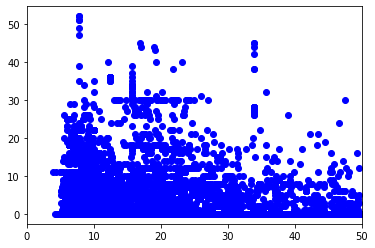

In [53]:
%matplotlib inline

plt.plot(near_df['distance'],near_df['brake'],'bo')

#plt.plot(df_full['distance'],df_full['brake'],'bo')
plt.xlim(0, 50)

plt.show()


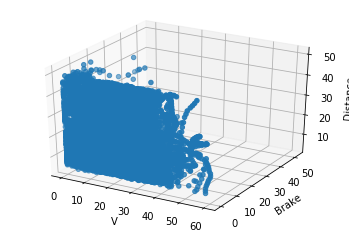

In [54]:
from mpl_toolkits.mplot3d import Axes3D  
%matplotlib qt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(near_df['ego_speed'],near_df['brake'],near_df['distance'],marker='o')
ax.set_xlabel('V')
ax.set_ylabel('Brake')
ax.set_zlabel('Distance')

plt.show()

Le premier modèle que je voulais faire était en utilisant la distance et la vitesse à l'instant t seulement.
Comme on peut le voir avec le graphique ci dessus,il est difficile d'imaginer un modèle qui pourrait correspondre à ce qu'on voit, c'est un pavé.
On voit bien qu'il est impossible de prédire quelque chose car les données sont représentés partout dans l'espace. Je vais essayer mainteant de rajouter des informations du passé (t-1,-2...) pour avoir plus de paramètres, et j'espère avoir un résultat concret.

## Affichage de la scène à partir d'un dataframe

Il pourrait être utile de visiualiser une scène même si on a pas charger le jeu de données, juste avec les .csv. Il pourrait même être intérressant de visualiser le choix du véhicule le plus proche sur ce graphique. C'est donc ce que j'ai fait i dessous.

In [56]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [58]:
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib qt
#liste_scene = ['scene-0061','scene-0010','scene-0041','scene-0009','scene-0100',
#'scene-0101','scene-0190','scene-0194']

# 61 41 190 194
def scene_animation(scene_name = 'scene-0006',loop = False, df = pd.DataFrame(),use_nuscenes=False):
    def animate(frame,arg):
        i = arg[frame]
        ego_pos = pos[pos['timestamp']==i]['ego_pos'].iloc[0]
        ego.set_data(ego_pos[0],ego_pos[1])

        df_curr = df[(df['timestamp']==i)&(df['inst_token']!='vehicle_info')]
        list_pos = df[(df['timestamp']==i)&(df['inst_token']!='vehicle_info')]['object_pos'].to_list()

        if len(list_pos)!=0 :
            #print(list_pos)
            a = np.transpose(np.asarray(list_pos))
            near_vehicle.set_data(a[0],a[1])

        text_ego.set_text(pos[pos['timestamp']==i].iloc[0,2])
        text_ego.set_x(pos[pos['timestamp']==i].iloc[0,1][0])
        text_ego.set_y(pos[pos['timestamp']==i].iloc[0,1][1])

        if frame < len(arg) - 2:
            j = arg[frame+1]
            A = pos[pos['timestamp']==i].iloc[0,1]
            B = pos[pos['timestamp']==j].iloc[0,1]
            AB =   [round(B[0] - A[0],3),round(B[1] - A[1],3)]
            if (AB[0]*AB[0] + AB[1]*AB[1]) == 0:
                ABn = (0,0)
            else:   
                ABn = round(AB[0]/np.sqrt((AB[0]*AB[0] + AB[1]*AB[1])),3),round(AB[1]/np.sqrt((AB[0]*AB[0] + AB[1]*AB[1])),3)
            vec_vitesse.set_data([A[0], A[0]+ABn[0]*10], [A[1],A[1]+ABn[1]*10])
            #vec_vitesse.set_data([100, 100+log[i][0]*100], [100,100+log[i][1]*100])
            if len(list_pos)!=0 :
                if ABn[0] == 0:
                    a = 0
                else:
                    a = ABn[1]/ABn[0]
                c = - A[0] * a + A[1]
                dmin = 50
                posmin = []
                inst_min = ""
                for index, o in df_curr.iterrows():
                    p = o['object_pos']
                    d = np.absolute(p[1] - a * p[0] - c)/ np.sqrt(a*a + 1)
                    distance_ego = round(np.linalg.norm(np.array(A) - np.array(p)),3)
                    if distance_ego < dmin and d < 3:
                        dmin = distance_ego
                        posmin = p
                        inst_min = o['inst_token']
                if posmin != []:
                    pmin.set_data(posmin[0],posmin[1])
                    text_dist.set_text(dmin)
                    text_dist.set_x(posmin[0])
                    text_dist.set_y(posmin[1])
                    # Affichage de l'instance du vehicule le pproche
                    #print(inst_min)
                else:
                    pmin.set_data([],[])
                #print(dmin,posmin)
                x = np.linspace(mini[0]-50, maxi[0]+50)
                y = a*x + c
                droiteAB.set_data(x,y)   
        #print(ABn)
        return ego,text_ego,text_dist,near_vehicle,vec_vitesse,pmin,droiteAB,
    
    # Initialisation 
    # Si aucun dataframe n'est fourni alors on le récupère, soit à travers le sdk nuscenes soit à partir
    # de df_full (chargé du csv ou calculer par build_dataframe_for_vehicle_in_front)
    if df.empty:
        if use_nuscenes:
            my_scene_token = nusc.field2token('scene', 'name', scene_name)[0]
            scene = nusc.get('scene',my_scene_token)
            df = build_dataframe_for_one_scene(scene,False)
        else:
            df = df_full[df_full['scene'] == scene_name]
    
    # On récupère une vue sut les lignes "vehicle_info" ainsi qu'une liste des timestamps de la scène
    df_ego = df[df['inst_token'] == "vehicle_info"]
    liste_temps = sorted(set(df['timestamp'].to_list()))

    # Attribution de valeur aux axes par rapport aux max/min 
    #plt.style.use(['dark_background'])
    fig, ax = plt.subplots()
    mini = df['ego_pos'].min()
    maxi = df['ego_pos'].max()
    plt.xlim(mini[0]-100, maxi[0]+100)
    plt.ylim(mini[1]-100, maxi[1]+100)

    pos = df_ego[['timestamp','ego_pos','ego_speed']]

    # Création des différents objets du graphique
    ego, = plt.plot(0, 0, 'o')
    near_vehicle, = plt.plot(0,0,'o')
    text_ego = plt.text(100,100,"")
    text_dist = plt.text(100,100,"_ego")
    vec_vitesse, = plt.plot(0,0,'-')
    pmin, = plt.plot(440,1100,'o')
    droiteAB, = plt.plot(0,0,'-')
    # Lancement animation
    print("Animation: ",df.iloc[0,:]['scene'])
    myAnimation = animation.FuncAnimation(fig, animate, frames=len(liste_temps),fargs=([liste_temps]),
                                          interval=250, blit=True, repeat=loop)
    plt.show()

scene_animation('scene-0006',True)

Animation:  scene-0006


## Ajout des données précédentes dans le dataframe

Comme je l'ai dit plus haut le premier modèle pour prédire la vitesse à l'instant t+1 ne devrait pas marcher car il ne prends pas compte des données précédentes, qui ensemble permettent d'avoir une évolution sur les derniers enregistrements de la situation, et donc, devrait être plus précis pour trouver une nouvelle vitesse, j'espère en tout cas. Voici une fonction pour ajouter les données précedentes dans le dataframe (non optimisé, cela prends un peu de temps sur toutes les scènes).

In [61]:
# Pas opti (copy, à améliorer)
# Ajout de colonnes dans le dataframe pour les informations antérieurs (distance + vitesse) normal + diff
def add_past_data_to_dataframe_v3(dataframe,k_past_data):
    clmns = dataframe.columns.to_list()
    for j in range(1,k_past_data+1):
        clmns += ['distance_'+str(j)] + ['ego_speed_'+str(j)] + ['d_diff_'+str(j)] + ['s_diff_'+str(j)]
    new_df = pd.DataFrame(columns=clmns)
    set_scene = sorted(set(dataframe['scene'].to_list()))
    for s in set_scene:
        df_curr =  dataframe[dataframe['scene']==s]
        for i in range(k_past_data,df_curr.shape[0]):
            row = df_curr.iloc[i].copy()
            for j in range(1,k_past_data+1):
                row['d_diff_'+str(j)]  = df_curr.iloc[i]['distance']  - df_curr.iloc[i-j]['distance'] 
                row['s_diff_'+str(j)] = df_curr.iloc[i]['ego_speed'] - df_curr.iloc[i-j]['ego_speed'] 
                row['distance_'+str(j)] = df_curr.iloc[i-j]['distance']
                row['ego_speed_'+str(j)] = df_curr.iloc[i-j]['ego_speed']
            new_df = new_df.append(row)
    #display(new_df)
    print(new_df.shape)
    return new_df        

# A decommenter
#near_df_past_data = add_past_data_to_dataframe_v3(near_df,5)
#features = [col for col in near_df_past_data.columns.to_list() if ('distance' in col or'ego_speed' in col)]
#print(near_df_past_data.columns,features)

# Exemple avec un jeu de données restreint
df = df_for_predict.copy()
df_with_past_data = add_past_data_to_dataframe_v3(df,5)

(195, 36)


## Autre méthode pour crée le jeu d'entrainement

Comme on peut le voir en affichant l'animation, ce n'est pas totalement précis et il arrive que certaines voitures qui ne soient pas sur la même voie sont détéctés en tant que voiture en face, pour palier ce problème, on peut par exemple: 
Remplir à la main pour chaque scène la voiture que l'on suit pour éviter d'avoir des fausses données, mais il y a un problème, si dans la scène cette voiture change, ça ne marchera pas, il faudrait dans ce cas la restreindre à un intervalle de timestamp (à faire). 
Mais pour un début de jeu d'entrainement cela permettra d'avoir au moins quelques données correctes. Voila 31 scènes sur les 300 premières (je n'ai accès qu'à celle la) qui me semble intéressante (accélération / ralentissement avec une voiture en face, arrêt à un feu derrière une voiture....), les autres scènes sont pas vraiment intéressante voir inexploitable (piéton, stop, changement de voie, ...).

In [62]:
# Nom scene, token instance
combi = [
         ('scene-0268','303d1654545a470ebbe247324d98bf8a'),
         ('scene-0256','a466d1fcc20944d7a092c44575602a3a'),
         ('scene-0253','4972136d347249b1a857608588c3aa0c'),
         ('scene-0252','a2e59b93a1f74e1da681364db24e8c1f'),
         ('scene-0251','17ca4b7e1aa14f2c836d998f0e033824'),
         ('scene-0249','d5eb9a3a504c4ce39d14dc38bddecc40'),
         ('scene-0244','f5d1d8b8417e4fe487a4bb9c7e523691'),
         ('scene-0243','6b679f56d3a9412499fe3a3542629cf6'),
         ('scene-0236','bba27d5c0b674d4e9906f93f26f76747'),
         ('scene-0235','f212f246f53e4110b7f6a490cc70adaa'),
         ('scene-0207','6a81ab78eee3477e8509569a5d0a2217'),
         ('scene-0194','ed77c0e17186414c97aa3bf4ea3ea162'),
         ('scene-0190','e49e2fd935074715a021e1c14827fb69'),
         ('scene-0102','83646f0a74de467f9c57efef379ceb3a'),
         ('scene-0041','5914d9b538ea44b9af49ab70cef66eee'),
         ('scene-0190','e49e2fd935074715a021e1c14827fb69'),
         ('scene-0194','ed77c0e17186414c97aa3bf4ea3ea162'),
         ('scene-0014','1d95a89e0f284f92a754704003ade0aa'),
         ('scene-0001','6efa17d08f464d72bbf5613e7149a5b0'),
         ('scene-0013','6e298f45ca39473887bfe3df4a71e34f'),
         ('scene-0015','fdf400507c2445d79f409033d63e9cd4'),
         ('scene-0016','7f790591ac9a4fe19cdd0a8d3a118880'),
         ('scene-0026','6834e14c29684039aa3a8990c83b1fcd'),
         ('scene-0033','5cf906b16d32462c969083ecfba88af9'),
         ('scene-0038','42d6c29a6b674264b1ae7ad8c3bda4a7'),
         ('scene-0039','53e005e24d204f0c95a6c2e9182c6a8b'),
         ('scene-0053','67119a38ed4f4873950026fe241a24eb'),
         ('scene-0033','5cf906b16d32462c969083ecfba88af9'),
         ('scene-0061','c1958768d48640948f6053d04cffd35b'),
         ('scene-0101','5b282658f35248ffb284d1e5d68ada8d'),
         ('scene-0006','98300b9c4acb4da9a7aecd0084650265')
        ]
# note:
# 1 (à couper), 13,15,16 (pas en entier),26, 27, 28 (début),33, (34?),36? fin,38,39,42,
# 43 debut, 45 debut (barriere), 46 debut (feu rouge, pas ouf), 53, 56 mouais,57
# 194  mouais à voir

In [63]:
df_hand = pd.DataFrame(columns=df_full.columns)
for s,i in combi:
    df_curr = df_full[(df_full['scene']==s)&((df_full['inst_token']==i)|(df_full['inst_token']=='vehicle_info'))]
    df_hand = df_hand.append(df_curr)
#df_hand.to_csv('./data/df_hand_proto1.csv')
df_hand_past = add_past_data_to_dataframe_v3(df_hand,5)
df_hand_past.to_csv('./data/df_hand_past_proto2407.csv')

(2076, 35)


In [65]:
liste_scene = sorted(set(df_hand_past['scene'].to_list()))
test = df_hand_past[df_hand_past['scene']=='scene-0061']
scene_animation(loop=True,df=test)

Animation:  scene-0061


On sépare en deux pour récupérer 2 scènes qui serviront à tester les modèles (la scène 6 on freine, la scene 101 on accelere).

In [66]:
cond = ((df_hand_past['scene']=='scene-0006') | (df_hand_past['scene']=='scene-0101'))
df_hand_past_train = df_hand_past[~cond]
df_hand_past_test = df_hand_past[~cond]
set(df_hand_past_train['scene'].to_list())

{'scene-0001',
 'scene-0013',
 'scene-0014',
 'scene-0015',
 'scene-0016',
 'scene-0026',
 'scene-0033',
 'scene-0038',
 'scene-0039',
 'scene-0041',
 'scene-0053',
 'scene-0061',
 'scene-0102',
 'scene-0190',
 'scene-0194',
 'scene-0207',
 'scene-0235',
 'scene-0236',
 'scene-0243',
 'scene-0244',
 'scene-0249',
 'scene-0251',
 'scene-0252',
 'scene-0253',
 'scene-0256',
 'scene-0268'}

## Matrice de corrélation sur un dataframe

On faisant une matrice de corrélation, on aperçoit que la distance entre les deux véhicules est influencé par la vitesse principalement, le frein, l'accélération et la distance, de même pour les enregistrements précédents

In [67]:
print(near_df_past_data.shape)
near_df_past_data.corr()

(12157, 37)


,Unnamed: 0,Unnamed: 0.1,timestamp,utime,distance,steering,ego_speed,throttle,brake,future_throttle,...,d_diff_3,s_diff_3,distance_4,ego_speed_4,d_diff_4,s_diff_4,distance_5,ego_speed_5,d_diff_5,s_diff_5
Unnamed: 0,1.000000,0.046131,0.865302,0.865302,-0.059719,-0.049794,0.074762,0.021558,0.064058,0.019729,...,0.009135,0.007842,-0.071451,0.072798,0.013058,0.006493,-0.077580,0.072203,0.019431,0.006409
Unnamed: 0.1,0.046131,1.000000,-0.050180,-0.050180,-0.073150,0.027523,-0.060076,0.020901,0.036448,0.022677,...,0.036329,-0.008210,-0.117655,-0.056165,0.046689,-0.011121,-0.133619,-0.054533,0.061129,-0.012618
timestamp,0.865302,-0.050180,1.000000,1.000000,-0.036237,-0.047046,0.171007,0.048644,0.035095,0.047044,...,0.010356,0.026061,-0.050615,0.161905,0.015318,0.026516,-0.057003,0.159149,0.021394,0.027521
utime,0.865302,-0.050180,1.000000,1.000000,-0.036237,-0.047046,0.171007,0.048644,0.035095,0.047044,...,0.010356,0.026061,-0.050615,0.161905,0.015318,0.026516,-0.057003,0.159149,0.021394,0.027521
distance,-0.059719,-0.073150,-0.036237,-0.036237,1.000000,0.012913,0.183698,0.075583,-0.113388,0.063653,...,0.452449,0.068822,0.509287,0.155393,0.481269,0.075359,0.445613,0.148335,0.500170,0.078029
steering,-0.049794,0.027523,-0.047046,-0.047046,0.012913,1.000000,0.026766,0.021444,-0.040879,0.017897,...,0.031483,0.021057,-0.021856,0.018680,0.035175,0.021004,-0.023046,0.018220,0.034316,0.018638
ego_speed,0.074762,-0.060076,0.171007,0.171007,0.183698,0.026766,1.000000,0.239540,-0.472936,0.186250,...,0.000845,0.183715,0.175077,0.922538,0.005374,0.216378,0.168809,0.891677,0.007775,0.244437
throttle,0.021558,0.020901,0.048644,0.048644,0.075583,0.021444,0.239540,1.000000,-0.281303,0.873735,...,0.060752,0.537616,0.003766,0.038780,0.071748,0.512795,-0.009983,0.013536,0.080040,0.487093
brake,0.064058,0.036448,0.035095,0.035095,-0.113388,-0.040879,-0.472936,-0.281303,1.000000,-0.274915,...,-0.002440,-0.175871,-0.107956,-0.404592,-0.003429,-0.182556,-0.107822,-0.387887,-0.001293,-0.188048
future_throttle,0.019729,0.022677,0.047044,0.047044,0.063653,0.017897,0.186250,0.873735,-0.274915,1.000000,...,0.058106,0.432827,-0.003743,0.025325,0.067466,0.410930,-0.013599,0.005572,0.072428,0.389340


In [68]:
print(df_hand_past.shape)
df_hand_past.corr()

(2076, 35)


,distance,steering,ego_speed,futur_speed,distance_1,ego_speed_1,d_diff_1,s_diff_1,distance_2,ego_speed_2,...,d_diff_3,s_diff_3,distance_4,ego_speed_4,d_diff_4,s_diff_4,distance_5,ego_speed_5,d_diff_5,s_diff_5
distance,1.000000,0.011738,0.204640,0.207224,-0.359275,0.201894,0.824937,0.042154,0.139395,0.196582,...,0.672770,0.080241,0.075499,0.188341,0.683695,0.093378,0.145981,0.182460,0.658306,0.103380
steering,0.011738,1.000000,-0.023479,-0.031012,0.014993,-0.021252,-0.001952,-0.026315,0.007274,-0.018896,...,-0.006835,-0.041079,0.007422,-0.014553,0.003242,-0.043372,0.005206,-0.012200,0.005070,-0.045358
ego_speed,0.204640,-0.023479,1.000000,0.996939,0.207890,0.996070,-0.001626,0.099376,0.207135,0.991994,...,-0.000069,0.167968,0.212053,0.977272,-0.003974,0.192835,0.212845,0.967044,-0.004508,0.215911
futur_speed,0.207224,-0.031012,0.996939,1.000000,0.208866,0.990084,-0.000648,0.132074,0.208073,0.983118,...,0.002010,0.214352,0.212210,0.963611,-0.002179,0.241629,0.212162,0.951445,-0.002000,0.263718
distance_1,-0.359275,0.014993,0.207890,0.208866,1.000000,0.201153,-0.823865,0.087174,-0.348483,0.198515,...,-0.374912,0.100376,0.107443,0.190420,-0.344118,0.099085,0.079794,0.185393,-0.337135,0.104889
ego_speed_1,0.201894,-0.021252,0.996070,0.990084,0.201153,1.000000,0.000787,0.010859,0.209222,0.995982,...,-0.000805,0.105650,0.210847,0.984500,-0.005120,0.140849,0.213529,0.976696,-0.007141,0.163472
d_diff_1,0.824937,-0.001952,-0.001626,-0.000648,-0.823865,0.000787,1.000000,-0.027196,0.295723,-0.000842,...,0.635669,-0.012061,-0.019220,-0.000944,0.623653,-0.003300,0.040332,-0.001471,0.604004,-0.000741
s_diff_1,0.042154,-0.026315,0.099376,0.132074,0.087174,0.010859,-0.027196,1.000000,-0.012009,0.009973,...,0.008271,0.709431,0.025261,-0.027229,0.012662,0.594730,0.004068,-0.055041,0.029338,0.601078
distance_2,0.139395,0.007274,0.207135,0.208073,-0.348483,0.209222,0.295723,-0.012009,1.000000,0.202604,...,0.368807,0.059122,0.142682,0.194541,-0.001417,0.076445,0.108353,0.191740,0.024802,0.077581
ego_speed_2,0.196582,-0.018896,0.991994,0.983118,0.198515,0.995982,-0.000842,0.009973,0.202604,1.000000,...,-0.006180,0.058813,0.209146,0.991684,-0.007801,0.088368,0.212429,0.984179,-0.010391,0.118780


# 3/ Apprentissage

Passons maintenant à l'apprentissage de modèles à partir des différents dataframes (near_df (past_data) et near qu'on a crée au cours de ce notebook, on va essayer de prédire la colonne "future_speed".

In [69]:
from sklearn.model_selection import train_test_split
from sklearn import svm, neighbors
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
import operator
import random

In [70]:
features = ["distance","ego_speed"]
Xfull = near_df[features]
yfull = near_df['futur_speed']
X_train, X_test, y_train, y_test = train_test_split(Xfull,yfull, test_size = 0.2,random_state=1)

On commence avec 3 modèles avec comme paramètre la distance et l'ego speed pour prédire la futur vitesse, une regression linéaire, une SVR, et une foret aleatoire.

In [86]:
dico_model = []
features = ["distance","ego_speed"]
model_reg = linear_model.LinearRegression()
model_reg.fit(X_train,y_train)
print(model_reg.score(X_test,y_test))
model_svr = svm.SVR()
model_svr.fit(X_train,y_train)
print(model_svr.score(X_test,y_test))
model_forest = RandomForestRegressor(n_estimators=100,random_state=0)
model_forest.fit(X_train,y_train)
print(model_forest.score(X_test,y_test))

dico_model += [{'model':model_reg,'features':features,'name':'Linear_Regression'}]
dico_model += [{'model':model_svr,'features':features,'name':'SVR'}]
dico_model += [{'model':model_forest,'features':features,'name':'Random_Forest'}]

0.9912672850027179
0.9903451280256642
0.9890119130423751


Une régression linéaire avec distance, egos_speed et distance, ego_speed de l'enregistrement précédent avec l'ensemble des scènes (near_df_past_data)

In [87]:
features = [col for col in df_with_past_data.columns.to_list() if ('distance' in col or'ego_speed' in col)]
features = features[:4]

train = near_df_past_data.iloc[:int(near_df_past_data.shape[0]*0.8),:]
test = near_df_past_data.iloc[int(near_df_past_data.shape[0]*0.8):,:]

model_reg_ndf_pd = linear_model.LinearRegression()
model_reg_ndf_pd.fit(train[features],train['futur_speed'])
print(model_reg_ndf_pd.score(test[features],test['futur_speed']))
print(model_reg_ndf_pd.score(df_hand_past_test[features],df_hand_past_test['futur_speed']))
dico_model += [{'model':model_reg_ndf_pd,'features':features,'name':'Linear_Regression_near_past_data'}]

model_forest_ndf_pd = RandomForestRegressor(n_estimators=100,random_state=0)
model_forest_ndf_pd.fit(train[features],train['futur_speed'])
print(model_forest_ndf_pd.score(test[features],test['futur_speed']))
print(model_forest_ndf_pd.score(df_hand_past_test[features],df_hand_past_test['futur_speed']))
dico_model += [{'model':model_forest_ndf_pd,'features':features,'name':'Random_Forest_near_past_data'}]

0.9963272254727255
0.9948616772585646
0.9850207261136733
0.9958546614449546


Une régression linéaire avec distance, egos_speed et distance, ego_speed de l'enregistrement précédent avec les scènes sélectionner manuellement (df_hand)

In [88]:
features = [col for col in df_hand_past.columns.to_list() if ('distance' in col or'ego_speed' in col)]
features = features[:4]
model_reg_hand_pd = linear_model.LinearRegression()
model_reg_hand_pd.fit(df_hand_past_train[features],df_hand_past_train['futur_speed'])
print(model_reg_hand_pd.score(test[features],test['futur_speed']))
print(model_reg_hand_pd.score(df_hand_past_test[features],df_hand_past_test['futur_speed']))
dico_model += [{'model':model_reg_hand_pd,'features':features,'name':'Linear_Regression_hand_past_data'}]

model_forest_hand_pd = RandomForestRegressor(n_estimators=100,random_state=0)
model_forest_hand_pd.fit(df_hand_past_train[features],df_hand_past_train['futur_speed'])
print(model_forest_hand_pd.score(test[features],test['futur_speed']))
print(model_forest_hand_pd.score(df_hand_past_test[features],df_hand_past_test['futur_speed']))
dico_model += [{'model':model_reg_hand_pd,'features':features,'name':'Random_Forest_hand_past_data'}]

0.9957690562749493
0.9952786417839309
0.9833253791770283
0.9995482130938957


Note: on peut changer pour avoir jusqu'à 5 enregistrements antérieur

Liste de dictionnaire contenant le modèle, les paramètres du modèle ainsi que son nom, servira plus tard pour les tests

In [89]:
dico_model

[{'model': LinearRegression(),
  'features': ['distance', 'ego_speed'],
  'name': 'Linear_Regression'},
 {'model': SVR(), 'features': ['distance', 'ego_speed'], 'name': 'SVR'},
 {'model': RandomForestRegressor(random_state=0),
  'features': ['distance', 'ego_speed'],
  'name': 'Random_Forest'},
 {'model': LinearRegression(),
  'features': ['distance', 'ego_speed', 'distance_1', 'ego_speed_1'],
  'name': 'Linear_Regression_near_past_data'},
 {'model': RandomForestRegressor(random_state=0),
  'features': ['distance', 'ego_speed', 'distance_1', 'ego_speed_1'],
  'name': 'Random_Forest_near_past_data'},
 {'model': LinearRegression(),
  'features': ['distance', 'ego_speed', 'distance_1', 'ego_speed_1'],
  'name': 'Linear_Regression_hand_past_data'},
 {'model': LinearRegression(),
  'features': ['distance', 'ego_speed', 'distance_1', 'ego_speed_1'],
  'name': 'Random_Forest_hand_past_data'}]

Testons ce modèle sur une scène afin de voir les prédictions, versions améliorer plus bas.

In [90]:
# Similaire aux fonctions de calcul de vecteur et d'animation plus haut
# On cherche la distance la plus petite au vehicule le plus proche
def compute_distance(pos,ABn,dataframe):
    dataframe = dataframe.drop(columns=['distance'])
    taille = dataframe.shape[0]
    dmin = 99
    mini = 0
    if ABn[0] == 0:
        a = 0
    else:
        a = ABn[1]/ABn[0]
    c = - pos[0] * a + pos[1]    
    for i in range(taille):
        row = dataframe.iloc[i]
        if row["inst_token"] != "vehicle_info":
            distance_ego = round(np.linalg.norm(np.array(pos) - np.array(row['object_pos'][:2])),3)
            distance_vecteur_vitesse = np.absolute(row['object_pos'][1] - a * row['object_pos'][0] - c)/ np.sqrt(a*a + 1)
            if distance_ego < dmin and distance_vecteur_vitesse < 5:
                dmin = distance_ego
                mini = i
    #print("Distance:",dmin," ",dataframe.iloc[mini]['inst_token']," ",dataframe.iloc[mini]['object_pos'])
    return dmin
    
# version simplifie pour pouvoir tester 
def compute_distance_cheat(pos,ABn,dataframe):
    df = dataframe[dataframe['inst_token']=="5b282658f35248ffb284d1e5d68ada8d"]
    if df.shape[0] == 0:
        return 99
    
    return round(np.linalg.norm(np.array(pos) - np.array(df.iloc[0]['object_pos'][:2])),3)

Fonction qui déroule une scene en affichant les prédictions de plusieurs modèles toutes les demi-secondes de la scène.
On peut soit utiliser les positions réellé de la scène ou calculer la nouvelle position avec la vitesse prédite (il faut commenter "B = df_ego.iloc[i]['ego_pos'][:2]"), par contre, pour que cette dernière marche, il faut que ce soit une scène avec un déplacement en ligne droite car 
la nouvelle position se calcul à partir d'un vecteur qui reste quasiment identique avec le calcul des nouvelles positions.

Si on prends une scène où la voiture ne suit pas une trajectoire linéaire (la 61 par exemple) les prédictions vont calculer la nouvelle position en ligne droite et donc ça ne marchera pas.

In [91]:
def predict_scene_v3(scene_name,k_past_data):

    df = df_hand_past[df_hand_past['scene']=='scene-0101']    
    df_ego = df[df['inst_token'] == "vehicle_info"]
    liste_tmsp = sorted(set(df['timestamp'].to_list()))
    nb_tmsp = len(liste_tmsp)
    
    # Initialisation des paramètres
    speed = df_ego.iloc[0]['ego_speed']
    A = df_ego.iloc[0]['ego_pos'][:2]
    B = df_ego.iloc[1]['ego_pos'][:2]
    print(A,B)
    A = [float(a) for a in A]
    B = [float(b) for b in B]

    log = []
    features = ["distance","ego_speed","throttle","brake"]
    i = 1
    throttle = [0]
    brake = [0]
    speed = 0

    past_data = [0]*k_past_data*2
    print("Position Predite,Position Reel,    Distance, vitesse, Prediction vitesse des différents modèles  ")
    
    # Parcours chaque demi secondes de la scène
    while i != nb_tmsp - 2:
        # Calcul vecteur vitesse et vecteur vitesse normalisé
        AB =   [round(B[0] - A[0],3),round(B[1] - A[1],3)]
        if AB[0]*AB[0] + AB[1]*AB[1] == 0:
            ABn = (0,0) 
        else:
            ABn = round(AB[0]/np.sqrt((AB[0]*AB[0] + AB[1]*AB[1])),3),round(AB[1]/np.sqrt((AB[0]*AB[0] + AB[1]*AB[1])),3)

            
        # On cherche la distance au véhicule le plus proche dans la direction où on va
        # Si scene 0061 remplacer par: compute_distance_cheat(B,ABn,df[df['timestamp']==liste_tmsp[i]])
        distance = compute_distance(B,ABn,df[df['timestamp']==liste_tmsp[i]])
        speed = df_ego.iloc[i]['ego_speed']

        # Paramètres des modèles
        data = [[distance,speed]]
        past_diff = []
        
        for j in range(len(past_data)):
            if j%2 == 0 and past_data[j] != 0:
                past_diff += [round(distance - past_data[j],3)]
            elif j%2 == 1 and past_data[j] != 0:
                past_diff += [round(speed - past_data[j],3)]
            else:
                past_diff += [past_data[j]]

        data2 = [distance,speed] + past_diff
        data3 = [distance,speed]+past_data
        
        # Application des modèles
        speed_predict = model_reg_hand_pd.predict([data3[:4]])
        speed = speed_predict[0] 
        speed = round(speed,3)

        if speed < 0:
            speed = 0 

        print(B,df_ego.iloc[i]['ego_pos'][:2],distance,speed,ABn,model_forest.predict(data), model_reg.predict(data),
              model_reg_ndf_pd.predict([data3[:4]]),
              model_reg_hand_pd.predict([data3[:4]]),"\n")
        past_data.append(distance)
        past_data.append(speed)
        past_data.pop(0)
        past_data.pop(0)
        i += 1
        # Calcul nouveau point
        deplacement = [e * speed/3.6*0.5 for e in ABn]     
        log += [ABn]
        A = B
        B = list(map(operator.add, B,deplacement))
        # Mettre en commentaire pour avoir la prédiction de la nouvelle position
        B = df_ego.iloc[i]['ego_pos'][:2]

        B = [round(b,3) for b in B]

    return log
scene_name = 'scene-0101'   
log = predict_scene_v3(scene_name,1)
#37efe5932d7f4084ac8ed3bbb5ed6220  56a9802dbe824219992d60debdea6646   23e14d768eab400099c816a3ac0ff041 98300b9c4acb4da9a7aecd0084650265       
#nusc.render_instance("98300b9c4acb4da9a7aecd0084650265")
print(len(log))
print(log)

[593.428, 1511.445] [593.428, 1511.445]
Position Predite,Position Reel,    Distance, vitesse, Prediction vitesse des différents modèles  
[593.428, 1511.445] [593.428, 1511.445] 99 0 (0, 0) [0.] [0.03811075] [-0.04264769] [-0.30173162] 

[593.428, 1511.445] [593.428, 1511.445] 99 0 (0, 0) [0.] [0.03811075] [0.05048389] [-0.26239142] 

[593.428, 1511.445] [593.428, 1511.445] 99 0 (0, 0) [0.] [0.03811075] [0.05048389] [-0.26239142] 

[593.428, 1511.445] [593.428, 1511.445] 99 0 (0, 0) [0.] [0.03811075] [0.05048389] [-0.26239142] 

[593.428, 1511.445] [593.428, 1511.445] 99 0 (0, 0) [0.] [0.03811075] [0.05048389] [-0.26239142] 

[593.423, 1511.447] [593.423, 1511.447] 11.514 1.754 (-0.928, 0.371) [1.1206] [1.58429803] [2.35914015] [1.753651] 

[593.296, 1511.523] [593.296, 1511.523] 12.553 3.341 (-0.858, 0.514) [3.1701] [3.22684615] [3.86953475] [3.34117234] 

[593.067, 1511.66] [593.067, 1511.66] 13.623 5.226 (-0.858, 0.513) [6.9517] [5.01871912] [5.74624599] [5.22586299] 

[592.553, 151

# 4/ Calcul score model

Essaie de réalisation d'une métrique en reprenant predict_scene, l'idée est d'utiliser un ensemble de scene et de calculer plusieurs scores basés sur 4 modes:
- Pas à pas, comparaison avec la vitesse réel
- Prédire tout le long la vitesse et faire une comparaison avec la vitesse réel
- Prédire à partir d'un certain moment
- Action correct: s'il y a décélération ou accélération dans la prediction et dans les données réelles
- Calculer la difference avec plusieurs vitesse en point de depart / constant


In [98]:
dico_model

[{'model': LinearRegression(),
  'features': ['distance', 'ego_speed'],
  'name': 'Linear_Regression'},
 {'model': SVR(), 'features': ['distance', 'ego_speed'], 'name': 'SVR'},
 {'model': RandomForestRegressor(random_state=0),
  'features': ['distance', 'ego_speed'],
  'name': 'Random_Forest'},
 {'model': LinearRegression(),
  'features': ['distance', 'ego_speed', 'distance_1', 'ego_speed_1'],
  'name': 'Linear_Regression_near_past_data'},
 {'model': RandomForestRegressor(random_state=0),
  'features': ['distance', 'ego_speed', 'distance_1', 'ego_speed_1'],
  'name': 'Random_Forest_near_past_data'},
 {'model': LinearRegression(),
  'features': ['distance', 'ego_speed', 'distance_1', 'ego_speed_1'],
  'name': 'Linear_Regression_hand_past_data'},
 {'model': LinearRegression(),
  'features': ['distance', 'ego_speed', 'distance_1', 'ego_speed_1'],
  'name': 'Random_Forest_hand_past_data'}]

On reprend les mêmes fonctions qu'au dessus

In [93]:
import matplotlib.patches as mpatches

# Similaire aux fonctions de calcul de vecteur et d'animation plus haut
# On cherche la distance la plus petite au vehicule le plus proche
def compute_distance(pos,ABn,dataframe):
    dataframe = dataframe.drop(columns=['distance'])
    taille = dataframe.shape[0]
    dmin = 99
    mini = 0
    if ABn[0] == 0:
        a = 0
    else:
        a = ABn[1]/ABn[0]
    c = - pos[0] * a + pos[1]    
    for i in range(taille):
        row = dataframe.iloc[i]
        if row["inst_token"] != "vehicle_info":
            distance_ego = round(np.linalg.norm(np.array(pos) - np.array(row['object_pos'][:2])),3)
            distance_vecteur_vitesse = np.absolute(row['object_pos'][1] - a * row['object_pos'][0] - c)/ np.sqrt(a*a + 1)
            if distance_ego < dmin and distance_vecteur_vitesse < 5:
                dmin = distance_ego
                mini = i
    #print("Distance:",dmin," ",dataframe.iloc[mini]['inst_token']," ",dataframe.iloc[mini]['object_pos'])
    return dmin
    
# Version simplifie pour pouvoir tester 
def compute_distance_cheat(pos,ABn,dataframe):
    df = dataframe[dataframe['inst_token']=="5b282658f35248ffb284d1e5d68ada8d"]
    if df.shape[0] == 0:
        return 99
    
    return round(np.linalg.norm(np.array(pos) - np.array(df.iloc[0]['object_pos'][:2])),3)

Fonctions beaucoup plus complète que la précédente, on peut lui fournir un large panel de paramètre pour effectuer les tests (modèle, liste de paramètres,dataframe,nom de la scène, mode).

In [94]:
def score_model_scene(model,features,df,scene_name="scene-xxxx",mode=0,affichage=False):
    print('\t',scene_name,':')
    #df = df_full[df_full["scene"] == scene_name]
    df_ego = df[df['inst_token'] == "vehicle_info"]
    
    liste_tmsp = sorted(set(df['timestamp'].to_list()))
    nb_tmsp = len(liste_tmsp)

    # Initialisation des paramètres
    speed = df_ego.iloc[0]['ego_speed']
    A = df_ego.iloc[0]['ego_pos'][:2]
    B = df_ego.iloc[1]['ego_pos'][:2]
    A = [float(a) for a in A]
    B = [float(b) for b in B]
    log = []
    i = 1
    throttle = [0]
    brake = [0]
    speed = df_ego.iloc[0]['ego_speed']

    k_past_data = int(len(features)/2 - 1)
    past_data = [0]*k_past_data*2
    erreur = 0
    sum_speed = 0
    
    # Parcours chaque demi secondes de la scène
    while i != nb_tmsp - 2:
        # Calcul vecteur vitesse et vecteur vitesse normalisé
        AB =   [round(B[0] - A[0],3),round(B[1] - A[1],3)]
        if AB[0]*AB[0] + AB[1]*AB[1] != 0:
            ABn = round(AB[0]/np.sqrt((AB[0]*AB[0] + AB[1]*AB[1])),3),round(AB[1]/np.sqrt((AB[0]*AB[0] + AB[1]*AB[1])),3)
        else:
            ABn = (0,0) 
            
        # On cherche la distance au véhicule le plus proche dans la direction où on va
        distance = compute_distance(B,ABn,df[df['timestamp']==liste_tmsp[i]])

        # Paramètres des modèles
        data = [[distance,speed]]
        past_diff = []
        
        for j in range(len(past_data)):
            if j%2 == 0 and past_data[j] != 0:
                past_diff += [round(distance - past_data[j],3)]
            elif j%2 == 1 and past_data[j] != 0:
                past_diff += [round(speed - past_data[j],3)]
            else:
                past_diff += [past_data[j]]

        data2 = [distance,speed] + past_diff
        data3 = [distance,speed ]+ past_data
        # Application des modèles
        speed_predict = model.predict([data3[:len(features)]])
        sum_speed += speed_predict[0] - df_ego.iloc[i]['ego_speed']
        erreur += pow(df_ego.iloc[i]['ego_speed'] - speed_predict[0],2)
        speed = round(speed,3)
    
        if speed < 0:
            speed = 0 
        if affichage:
            print(B,df_ego.iloc[i]['ego_pos'][:2],distance,speed,ABn,speed_predict[0])
        past_data.append(distance)
        past_data.append(speed)
        past_data.pop(0)
        past_data.pop(0)
        i += 1
        
        # Calcul nouveau point
        A = B
        if mode == 0:
            B = df_ego.iloc[i]['ego_pos'][:2]
            speed = df_ego.iloc[i]['ego_speed']
        elif mode == 1:
            speed = speed_predict[0]
            if speed < 0:
                speed = 0
            deplacement = [e * speed/3.6*0.5 for e in ABn]        
            B = list(map(operator.add, B,deplacement))
        log += [(df_ego.iloc[i]['ego_speed'],speed_predict)]
        B = [round(b,3) for b in B]
    print()
    print("\t\tErreur quadratique:",erreur)
    print("\t\tSomme vitesse cumulée:",sum_speed)
    print("\t\tVitesse moyenne:",sum_speed/i)
    return log

Maintenant on fait les tests.

In [97]:
for m in dico_model:
    print(m['name'])
    liste_scene_score = ['scene-0006','scene-0101']
    #fig = plt.subplot(1,3)
    for i in range(len(liste_scene_score)):
        if liste_scene_score[i] == 'scene-0101':
            df = df_hand_past[df_hand_past['scene']==liste_scene_score[i]].iloc[8:,:]
        else:
            df = df_hand_past[df_hand_past['scene']==liste_scene_score[i]].iloc[8:,:]
        log = score_model_scene(m['model'],m['features'],df,liste_scene_score[i],0)
        ax = plt.subplot(2,2,(i+1))
        x1 = [a for a,_ in log]
        x2 = [b for _,b in log]
        l1 = ax.plot(x1)
        l2 = ax.plot(x2)
        ax.set_title(liste_scene_score[i])
        patch = mpatches.Patch(color=l1[0].get_color(), label='Vitesse réelle')
        patch2 = mpatches.Patch(color=l2[0].get_color(), label='Vitesse prédite')
        ax.legend(handles=[patch,patch2])

    for i in range(len(liste_scene_score)):
        if liste_scene_score[i] == 'scene-0101':
            df = df_hand_past[df_hand_past['scene']==liste_scene_score[i]].iloc[8:,:]
        else:
            df = df_hand_past[df_hand_past['scene']==liste_scene_score[i]].iloc[8:,:]        
        log = score_model_scene(m['model'],m['features'],df,liste_scene_score[i],1)
        ax = plt.subplot(2,2,(i+3))
        x1 = [a for a,b in log]
        x2 = [b for a,b in log]
        l1 = ax.plot(x1)
        l2 = ax.plot(x2)

        ax.set_title(liste_scene_score[i])
        patch = mpatches.Patch(color=l1[0].get_color(), label='Vitesse réelle')
        patch2 = mpatches.Patch(color=l2[0].get_color(), label='Vitesse prédite')
        ax.legend(handles=[patch,patch2])
        
    plt.suptitle(m['name']+' Features: '+','.join(m['features']), fontsize=14)
    plt.show(block=True)
        

#print(len(log))
#print(log)


Linear_Regression
	 scene-0006 :

		Erreur quadratique: 0.9579277272710789
		Somme vitesse cumulée: 0.08344455587161015
		Vitesse moyenne: 0.002691759866826134
	 scene-0101 :

		Erreur quadratique: 2.4598285846633825
		Somme vitesse cumulée: -3.3842283931972683
		Vitesse moyenne: -0.10916865784507317
	 scene-0006 :

		Erreur quadratique: 2835.8750432286797
		Somme vitesse cumulée: 276.9091208963725
		Vitesse moyenne: 8.932552286979758
	 scene-0101 :

		Erreur quadratique: 17686.5343257908
		Somme vitesse cumulée: -659.0574658733442
		Vitesse moyenne: -21.259918253978846
SVR
	 scene-0006 :

		Erreur quadratique: 1781.6083981572717
		Somme vitesse cumulée: 163.01159910819553
		Vitesse moyenne: 5.258438680909533
	 scene-0101 :

		Erreur quadratique: 700.0694724930048
		Somme vitesse cumulée: -83.23446893370824
		Vitesse moyenne: -2.684982868829298
	 scene-0006 :

		Erreur quadratique: 3098.9309396748667
		Somme vitesse cumulée: 288.3512438379093
		Vitesse moyenne: 9.301653027029332
	 scen

On peut voir que les résultats ne sont pas térribles, la plupart des modèles se débrouille sur la scène où il faut freiner dans les deux modes, même si dans le deuxième mode le ralentissement n'est pas incroyable mais il est présent c'est plutôt pas mal. Par contre pour la scène de l'accélération ce n'est pas térrible, la plupart des modèles restent à 0.

## Amélioration modèle 

Suite de deux essais pour améliorer un modèle en partant d'un ensemble de scène qu'on fait grosser au fur et à mesure pour améliorer le score du modèle. Après avoir fait quelques tests, cela ne marche pas, et je n'ai pas eu le temps d'avancer sur cette partie.

### Modèle basique: distance + ego_speed

In [60]:
features = ["distance","ego_speed"]
df = df_for_predict.copy()
y = df["futur_speed"]
X = df[features]
Xnear = near_df[features]
ynear = near_df['futur_speed']
_, X_test, _, y_test = train_test_split(Xnear,ynear, test_size = 0.2, random_state = 1)
model_b2 = RandomForestRegressor(n_estimators=100,random_state=0)
model_b2.fit(X,y)
best_score = 0
print("Score initial: ",best_score)

scenes  = list(sorted(set(near_df['scene'].to_list())))
scenes_in_df = list(sorted(set(df['scene'].to_list())))
scenes = scenes[:200]
taille = len(scenes)
i = 0
for s in scenes:
    if i % (taille/10) == 0:
        print(i,score)
    if s not in scenes_in_df:
        df_curr = near_df[near_df['scene']==s]
        X = df[features]
        X = X.append(df_curr[features],ignore_index=True)
        y = df["futur_speed"]
        y = y.append(df_curr["futur_speed"],ignore_index=True)
        model_b2.fit(X,y)
        score = model_b2.score(X_test,y_test)
        if score > best_score:
            df = df.append(df_curr,ignore_index=True)
            best_score = score
    i += 1
print("Score finale: ",best_score)


Score initial:  0
0 0.9860969533645148


### Modele avancé: distance + speed + données antérieurs

In [133]:
features = ["distance","ego_speed"]
# if ('distance' in col or'ego_speed' in col)
features = [col for col in near_df_past_data.columns.to_list() if ('diff' in col in col)]
print(features)

['d_diff_1', 's_diff_1', 'd_diff_2', 's_diff_2', 'd_diff_3', 's_diff_3', 'd_diff_4', 's_diff_4', 'd_diff_5', 's_diff_5']


In [36]:
features = ['distance','ego_speed'] + [col for col in near_df_past_data.columns.to_list() if ('diff' in col)][:4]
df = df_with_past_data.copy()
X = df[features]
y = df["futur_speed"]

train = near_df_past_data.iloc[:int(near_df_past_data.shape[0]*0.8),:]
test = near_df_past_data.iloc[int(near_df_past_data.shape[0]*0.8):,:]
#svm.SVR()
model_reg2 = svm.SVR()
#model_b5 = svm.SVR()

model_reg2.fit(train[features],train['futur_speed'])
best_score = model_reg2.score(test[features],test['futur_speed'])
print("Score initial: ",best_score)
print(features)

Score initial:  0.9817899263988592
['distance', 'ego_speed', 'd_diff_1', 's_diff_1', 'd_diff_2', 's_diff_2']


In [103]:
features = [col for col in near_df_past_data.columns.to_list() if ('diff' in col)]
df = df_with_past_data.copy()
X = df[features]
y = df["futur_speed"]

train = near_df_past_data.iloc[:int(near_df_past_data.shape[0]*0.8),:]
test = near_df_past_data.iloc[int(near_df_past_data.shape[0]*0.8):,:]
#svm.SVR()
model_b5 = RandomForestRegressor(n_estimators=100,random_state=0)
#model_b5 = svm.SVR()

model_b5.fit(X,y)
best_score = 0
print("Score initial: ",best_score)

scenes  = list(sorted(set(train['scene'].to_list())))
scenes_in_df = list(sorted(set(df['scene'].to_list())))
scenes = scenes[:200]
taille = len(scenes)
i = 0
for s in scenes:
    #print(s)
    if i % (taille/10) == 0:
        #print(s,':',score,len(X))
        pass

    
    if s not in scenes_in_df:
        df_curr = train[train['scene']==s]
        X = df[features]
        X = X.append(df_curr[features],ignore_index=True)
        y = df["futur_speed"]
        y = y.append(df_curr["futur_speed"],ignore_index=True)
        model_b5.fit(X,y)
        score = model_b5.score(test[features],test['futur_speed'])

        if score > best_score:
            df = df.append(df_curr,ignore_index=True)
            best_score = score
            print(s,':',score,len(X))
    i += 1
print("Score final: ",score)

Score initial:  0
scene-0001 : 0.24444979970190328 219
scene-0002 : 0.24150267128023195 229
scene-0004 : 0.24238101444151505 246
scene-0005 : 0.25490290395938353 277
scene-0006 : 0.23163449355437415 297
scene-0007 : 0.25448109006239805 306
scene-0008 : 0.253151697428598 317
scene-0011 : 0.2494930887568908 346
scene-0013 : 0.24788272456892668 377
scene-0014 : 0.24867108454034603 400
scene-0015 : 0.26339950018251834 432
scene-0016 : 0.2638068406392885 446
scene-0017 : 0.25760647783845314 457
scene-0018 : 0.24841829446217656 481
scene-0020 : 0.24563856326474998 491
scene-0021 : 0.1967075529479807 511
scene-0022 : 0.19912822718681233 516
scene-0023 : 0.198516650666255 518
scene-0024 : 0.19681193598516122 523
scene-0026 : 0.19634519746547308 540
scene-0027 : 0.19227045123999598 545
scene-0028 : 0.19542510566258342 554
scene-0030 : 0.20167941438324044 567
scene-0031 : 0.20095753960632223 576
scene-0033 : 0.21051030707132934 580
scene-0034 : 0.20500467689960278 587
scene-0035 : 0.198512353483

# Conclusion

Ceci conclut ce notebook, nous avons d'abord rechercher les données qui allaient nous aider. Puis nous les avons rassemblés et traiter afin d'en réduire le nombre. Finalement nous avons essayé de trouver des modèles pour prédire la vitesse, le résultat final n'est pas térrible, mais il donne déjà une bonne idée du potentiel.